In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h[-1]
beta = beta[-1]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-8],]

In [9]:
cm_target

['case15cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (5000, 2)
Dimension - heights of Gurney flaps:  (5000, 1)
Dimension - inclination(beta):  (5000, 1)
Dimension - x:  (5000, 3)
Dimension - y:  (5000, 1)


In [19]:
x[:,0] -= 10
x[:,0] /= 5

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221229\\WithParameters"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_WithParameters_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.1880 - rmse: 0.4335
Epoch 1: val_loss improved from inf to 0.15136, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 2s 137ms/step - loss: 0.1817 - rmse: 0.4262 - val_loss: 0.1514 - val_rmse: 0.3889 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1461 - rmse: 0.3821
Epoch 2: val_loss improved from 0.15136 to 0.12156, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.1429 - rmse: 0.3779 - val_loss: 0.1216 - val_rmse: 0.3485 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1217 - rmse: 0.3487
Epoch 3: val_loss improved from 0.12156 to 0.09892, sa

3/3 [==============================] - 0s 42ms/step - loss: 0.0628 - rmse: 0.2504 - val_loss: 0.0603 - val_rmse: 0.2454 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0639 - rmse: 0.2525
Epoch 23: val_loss improved from 0.06033 to 0.06030, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0630 - rmse: 0.2509 - val_loss: 0.0603 - val_rmse: 0.2453 - lr: 1.0000e-04
Epoch 24/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0641 - rmse: 0.2531
Epoch 24: val_loss did not improve from 0.06030
3/3 [==============================] - 0s 17ms/step - loss: 0.0635 - rmse: 0.2519 - val_loss: 0.0603 - val_rmse: 0.2453 - lr: 1.0000e-04
Epoch 25/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0659 - rmse: 0.2566
Epoch 25: val_loss improved from 0.06030 to 0.06028, saving mod

Epoch 43/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0652 - rmse: 0.2551
Epoch 43: val_loss did not improve from 0.06017
3/3 [==============================] - 0s 18ms/step - loss: 0.0648 - rmse: 0.2544 - val_loss: 0.0602 - val_rmse: 0.2451 - lr: 1.0000e-04
Epoch 44/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0634 - rmse: 0.2515
Epoch 44: val_loss improved from 0.06017 to 0.06017, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0627 - rmse: 0.2503 - val_loss: 0.0602 - val_rmse: 0.2451 - lr: 1.0000e-04
Epoch 45/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0622 - rmse: 0.2491
Epoch 45: val_loss improved from 0.06017 to 0.06016, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h

3/3 [==============================] - 0s 48ms/step - loss: 0.0646 - rmse: 0.2539 - val_loss: 0.0601 - val_rmse: 0.2449 - lr: 1.0000e-04
Epoch 65/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0623 - rmse: 0.2493
Epoch 65: val_loss improved from 0.06010 to 0.06010, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0639 - rmse: 0.2525 - val_loss: 0.0601 - val_rmse: 0.2449 - lr: 1.0000e-04
Epoch 66/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0598 - rmse: 0.2443
Epoch 66: val_loss improved from 0.06010 to 0.06009, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0627 - rmse: 0.2502 - val_loss: 0.0601 - val_rmse: 0.2449 - lr: 1.0000e-04
E

3/3 [==============================] - 0s 50ms/step - loss: 0.0632 - rmse: 0.2512 - val_loss: 0.0600 - val_rmse: 0.2448 - lr: 1.0000e-04
Epoch 85/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0651 - rmse: 0.2550
Epoch 85: val_loss improved from 0.06001 to 0.06000, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0632 - rmse: 0.2512 - val_loss: 0.0600 - val_rmse: 0.2448 - lr: 1.0000e-04
Epoch 86/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0633 - rmse: 0.2514
Epoch 86: val_loss improved from 0.06000 to 0.06000, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0642 - rmse: 0.2532 - val_loss: 0.0600 - val_rmse: 0.2447 - lr: 1.0000e-04
E

3/3 [==============================] - 0s 52ms/step - loss: 0.0627 - rmse: 0.2502 - val_loss: 0.0599 - val_rmse: 0.2445 - lr: 1.0000e-04
Epoch 104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0656 - rmse: 0.2559
Epoch 104: val_loss improved from 0.05989 to 0.05988, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0634 - rmse: 0.2515 - val_loss: 0.0599 - val_rmse: 0.2445 - lr: 1.0000e-04
Epoch 105/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0608 - rmse: 0.2463
Epoch 105: val_loss improved from 0.05988 to 0.05987, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0628 - rmse: 0.2504 - val_loss: 0.0599 - val_rmse: 0.2445 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 0.0651 - rmse: 0.2549
Epoch 124: val_loss improved from 0.05972 to 0.05970, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0622 - rmse: 0.2491 - val_loss: 0.0597 - val_rmse: 0.2441 - lr: 1.0000e-04
Epoch 125/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0638 - rmse: 0.2525
Epoch 125: val_loss improved from 0.05970 to 0.05970, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0620 - rmse: 0.2488 - val_loss: 0.0597 - val_rmse: 0.2441 - lr: 1.0000e-04
Epoch 126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0683 - rmse: 0.2611
Epoch 126: val_loss did not improve from 0.05970
3/3 [===

1/3 [=========>....................] - ETA: 0s - loss: 0.0583 - rmse: 0.2412
Epoch 145: val_loss improved from 0.05946 to 0.05946, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0612 - rmse: 0.2472 - val_loss: 0.0595 - val_rmse: 0.2436 - lr: 1.0000e-04
Epoch 146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0716 - rmse: 0.2674
Epoch 146: val_loss did not improve from 0.05946
3/3 [==============================] - 0s 23ms/step - loss: 0.0648 - rmse: 0.2543 - val_loss: 0.0595 - val_rmse: 0.2437 - lr: 1.0000e-04
Epoch 147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0608 - rmse: 0.2464
Epoch 147: val_loss did not improve from 0.05946
3/3 [==============================] - 0s 21ms/step - loss: 0.0623 - rmse: 0.2495 - val_loss: 0.0595 - val_rmse: 0.2437 - lr: 1.0000e-04
Epoch 148/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2345
Epoch 166: val_loss did not improve from 0.05915
3/3 [==============================] - 0s 21ms/step - loss: 0.0608 - rmse: 0.2463 - val_loss: 0.0592 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0619 - rmse: 0.2486
Epoch 167: val_loss did not improve from 0.05915
3/3 [==============================] - 0s 21ms/step - loss: 0.0615 - rmse: 0.2479 - val_loss: 0.0592 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0638 - rmse: 0.2524
Epoch 168: val_loss improved from 0.05915 to 0.05907, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 66ms/step - loss: 0.0634 - rmse: 0.2515 - val_loss: 0.0591 - val_rmse: 0.2428 - lr: 1.0000e-04
Epoch 169/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0631 - rmse: 0.2509
Epoch 187: val_loss improved from 0.05861 to 0.05857, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0609 - rmse: 0.2465 - val_loss: 0.0586 - val_rmse: 0.2418 - lr: 1.0000e-04
Epoch 188/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0651 - rmse: 0.2550
Epoch 188: val_loss improved from 0.05857 to 0.05854, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0630 - rmse: 0.2508 - val_loss: 0.0585 - val_rmse: 0.2417 - lr: 1.0000e-04
Epoch 189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0679 - rmse: 0.2603
Epoch 189: val_loss did not improve from 0.05854
3/3 [===

Epoch 208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0606 - rmse: 0.2460
Epoch 208: val_loss improved from 0.05785 to 0.05777, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0594 - rmse: 0.2434 - val_loss: 0.0578 - val_rmse: 0.2401 - lr: 1.0000e-04
Epoch 209/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0632 - rmse: 0.2512
Epoch 209: val_loss improved from 0.05777 to 0.05772, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0621 - rmse: 0.2490 - val_loss: 0.0577 - val_rmse: 0.2400 - lr: 1.0000e-04
Epoch 210/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2321
Epoch 210: val_loss improved from 0.05772

3/3 [==============================] - 0s 46ms/step - loss: 0.0607 - rmse: 0.2461 - val_loss: 0.0569 - val_rmse: 0.2383 - lr: 1.0000e-04
Epoch 228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0619 - rmse: 0.2486
Epoch 228: val_loss improved from 0.05687 to 0.05677, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0614 - rmse: 0.2476 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0565 - rmse: 0.2376
Epoch 229: val_loss improved from 0.05677 to 0.05666, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0592 - rmse: 0.2431 - val_loss: 0.0567 - val_rmse: 0.2378 - lr: 1.0000e-

Epoch 247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0568 - rmse: 0.2381
Epoch 247: val_loss improved from 0.05563 to 0.05560, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0571 - rmse: 0.2388 - val_loss: 0.0556 - val_rmse: 0.2356 - lr: 1.0000e-04
Epoch 248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0583 - rmse: 0.2413
Epoch 248: val_loss did not improve from 0.05560
3/3 [==============================] - 0s 21ms/step - loss: 0.0589 - rmse: 0.2424 - val_loss: 0.0556 - val_rmse: 0.2357 - lr: 1.0000e-04
Epoch 249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0595 - rmse: 0.2438
Epoch 249: val_loss improved from 0.05560 to 0.05554, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkp

Epoch 267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2370
Epoch 267: val_loss improved from 0.05446 to 0.05439, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0577 - rmse: 0.2401 - val_loss: 0.0544 - val_rmse: 0.2330 - lr: 1.0000e-04
Epoch 268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0588 - rmse: 0.2423
Epoch 268: val_loss improved from 0.05439 to 0.05434, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0584 - rmse: 0.2415 - val_loss: 0.0543 - val_rmse: 0.2329 - lr: 1.0000e-04
Epoch 269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2483
Epoch 269: val_loss improved from 0.05434

3/3 [==============================] - 0s 46ms/step - loss: 0.0570 - rmse: 0.2385 - val_loss: 0.0527 - val_rmse: 0.2294 - lr: 1.0000e-04
Epoch 288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2347
Epoch 288: val_loss improved from 0.05273 to 0.05270, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0563 - rmse: 0.2370 - val_loss: 0.0527 - val_rmse: 0.2293 - lr: 1.0000e-04
Epoch 289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0566 - rmse: 0.2378
Epoch 289: val_loss improved from 0.05270 to 0.05260, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0565 - rmse: 0.2374 - val_loss: 0.0526 - val_rmse: 0.2291 - lr: 1.0000e-

3/3 [==============================] - 0s 56ms/step - loss: 0.0555 - rmse: 0.2353 - val_loss: 0.0510 - val_rmse: 0.2256 - lr: 1.0000e-04
Epoch 309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0565 - rmse: 0.2375
Epoch 309: val_loss improved from 0.05101 to 0.05090, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0534 - rmse: 0.2308 - val_loss: 0.0509 - val_rmse: 0.2254 - lr: 1.0000e-04
Epoch 310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0630 - rmse: 0.2509
Epoch 310: val_loss improved from 0.05090 to 0.05081, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0560 - rmse: 0.2365 - val_loss: 0.0508 - val_rmse: 0.2252 - lr: 1.0000e-

3/3 [==============================] - 0s 53ms/step - loss: 0.0508 - rmse: 0.2251 - val_loss: 0.0488 - val_rmse: 0.2208 - lr: 1.0000e-04
Epoch 329/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0506 - rmse: 0.2247
Epoch 329: val_loss improved from 0.04883 to 0.04873, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0517 - rmse: 0.2271 - val_loss: 0.0487 - val_rmse: 0.2205 - lr: 1.0000e-04
Epoch 330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0573 - rmse: 0.2392
Epoch 330: val_loss did not improve from 0.04873
3/3 [==============================] - 0s 21ms/step - loss: 0.0529 - rmse: 0.2297 - val_loss: 0.0488 - val_rmse: 0.2207 - lr: 1.0000e-04
Epoch 331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2303
Epoch 331: val_loss did not improve from 0.04873
3/3 [====

Epoch 350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0546 - rmse: 0.2334
Epoch 350: val_loss improved from 0.04654 to 0.04652, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0513 - rmse: 0.2262 - val_loss: 0.0465 - val_rmse: 0.2155 - lr: 1.0000e-04
Epoch 351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0517 - rmse: 0.2272
Epoch 351: val_loss did not improve from 0.04652
3/3 [==============================] - 0s 20ms/step - loss: 0.0495 - rmse: 0.2223 - val_loss: 0.0467 - val_rmse: 0.2158 - lr: 1.0000e-04
Epoch 352/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2280
Epoch 352: val_loss did not improve from 0.04652
3/3 [==============================] - 0s 20ms/step - loss: 0.0510 - rmse: 0.2257 - val_loss: 0.0466 - val_rmse: 0.2157 - lr: 1.0000e-04
Epoch 353

1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2252
Epoch 371: val_loss did not improve from 0.04459
3/3 [==============================] - 0s 21ms/step - loss: 0.0512 - rmse: 0.2260 - val_loss: 0.0447 - val_rmse: 0.2112 - lr: 1.0000e-04
Epoch 372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2200
Epoch 372: val_loss did not improve from 0.04459
3/3 [==============================] - 0s 20ms/step - loss: 0.0471 - rmse: 0.2169 - val_loss: 0.0461 - val_rmse: 0.2146 - lr: 1.0000e-04
Epoch 373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0482 - rmse: 0.2194
Epoch 373: val_loss did not improve from 0.04459
3/3 [==============================] - 0s 20ms/step - loss: 0.0488 - rmse: 0.2208 - val_loss: 0.0462 - val_rmse: 0.2146 - lr: 1.0000e-04
Epoch 374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0506 - rmse: 0.2247
Epoch 374: val_loss did not improve from 0.04459
3/3 [==============================] 

3/3 [==============================] - 0s 20ms/step - loss: 0.0467 - rmse: 0.2159 - val_loss: 0.0432 - val_rmse: 0.2076 - lr: 1.0000e-04
Epoch 395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0462 - rmse: 0.2148
Epoch 395: val_loss did not improve from 0.04316
3/3 [==============================] - 0s 21ms/step - loss: 0.0467 - rmse: 0.2159 - val_loss: 0.0440 - val_rmse: 0.2096 - lr: 1.0000e-04
Epoch 396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0453 - rmse: 0.2125
Epoch 396: val_loss did not improve from 0.04316
3/3 [==============================] - 0s 21ms/step - loss: 0.0470 - rmse: 0.2167 - val_loss: 0.0445 - val_rmse: 0.2108 - lr: 1.0000e-04
Epoch 397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0453 - rmse: 0.2126
Epoch 397: val_loss did not improve from 0.04316
3/3 [==============================] - 0s 20ms/step - loss: 0.0475 - rmse: 0.2177 - val_loss: 0.0440 - val_rmse: 0.2096 - lr: 1.0000e-04
Epoch 398/10000
1/3 [=====

3/3 [==============================] - 0s 21ms/step - loss: 0.0442 - rmse: 0.2101 - val_loss: 0.0416 - val_rmse: 0.2038 - lr: 1.0000e-04
Epoch 419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2179
Epoch 419: val_loss did not improve from 0.04138
3/3 [==============================] - 0s 20ms/step - loss: 0.0459 - rmse: 0.2141 - val_loss: 0.0418 - val_rmse: 0.2043 - lr: 1.0000e-04
Epoch 420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0475 - rmse: 0.2177
Epoch 420: val_loss did not improve from 0.04138
3/3 [==============================] - 0s 20ms/step - loss: 0.0450 - rmse: 0.2119 - val_loss: 0.0414 - val_rmse: 0.2033 - lr: 1.0000e-04
Epoch 421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0437 - rmse: 0.2088
Epoch 421: val_loss did not improve from 0.04138
3/3 [==============================] - 0s 21ms/step - loss: 0.0446 - rmse: 0.2110 - val_loss: 0.0414 - val_rmse: 0.2033 - lr: 1.0000e-04
Epoch 422/10000
1/3 [=====

3/3 [==============================] - 0s 45ms/step - loss: 0.0424 - rmse: 0.2057 - val_loss: 0.0399 - val_rmse: 0.1995 - lr: 1.0000e-04
Epoch 443/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0429 - rmse: 0.2068
Epoch 443: val_loss improved from 0.03989 to 0.03983, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0440 - rmse: 0.2095 - val_loss: 0.0398 - val_rmse: 0.1993 - lr: 1.0000e-04
Epoch 444/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0429 - rmse: 0.2068
Epoch 444: val_loss did not improve from 0.03983
3/3 [==============================] - 0s 20ms/step - loss: 0.0430 - rmse: 0.2071 - val_loss: 0.0403 - val_rmse: 0.2006 - lr: 1.0000e-04
Epoch 445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0436 - rmse: 0.2087
Epoch 445: val_loss improved from 0.03983 to 0.03971, savi

Epoch 466/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0448 - rmse: 0.2114
Epoch 466: val_loss did not improve from 0.03847
3/3 [==============================] - 0s 20ms/step - loss: 0.0435 - rmse: 0.2084 - val_loss: 0.0389 - val_rmse: 0.1970 - lr: 1.0000e-04
Epoch 467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2008
Epoch 467: val_loss did not improve from 0.03847
3/3 [==============================] - 0s 20ms/step - loss: 0.0413 - rmse: 0.2031 - val_loss: 0.0390 - val_rmse: 0.1974 - lr: 1.0000e-04
Epoch 468/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0402 - rmse: 0.2004
Epoch 468: val_loss did not improve from 0.03847
3/3 [==============================] - 0s 20ms/step - loss: 0.0418 - rmse: 0.2043 - val_loss: 0.0390 - val_rmse: 0.1973 - lr: 1.0000e-04
Epoch 469/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2023
Epoch 469: val_loss improved from 0.03847 to 0.03832, saving model to 

3/3 [==============================] - 0s 48ms/step - loss: 0.0424 - rmse: 0.2057 - val_loss: 0.0367 - val_rmse: 0.1912 - lr: 1.0000e-04
Epoch 492/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2023
Epoch 492: val_loss improved from 0.03667 to 0.03655, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0397 - rmse: 0.1990 - val_loss: 0.0366 - val_rmse: 0.1909 - lr: 1.0000e-04
Epoch 493/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1881
Epoch 493: val_loss did not improve from 0.03655
3/3 [==============================] - 0s 20ms/step - loss: 0.0395 - rmse: 0.1985 - val_loss: 0.0368 - val_rmse: 0.1915 - lr: 1.0000e-04
Epoch 494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0441 - rmse: 0.2097
Epoch 494: val_loss did not improve from 0.03655
3/3 [====

Epoch 516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0381 - rmse: 0.1948
Epoch 516: val_loss improved from 0.03541 to 0.03539, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 1s 310ms/step - loss: 0.0384 - rmse: 0.1957 - val_loss: 0.0354 - val_rmse: 0.1879 - lr: 1.0000e-04
Epoch 517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0371 - rmse: 0.1924
Epoch 517: val_loss did not improve from 0.03539
3/3 [==============================] - 0s 21ms/step - loss: 0.0378 - rmse: 0.1943 - val_loss: 0.0357 - val_rmse: 0.1886 - lr: 1.0000e-04
Epoch 518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0415 - rmse: 0.2036
Epoch 518: val_loss improved from 0.03539 to 0.03514, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_check

Epoch 540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0347 - rmse: 0.1859
Epoch 540: val_loss did not improve from 0.03370
3/3 [==============================] - 0s 20ms/step - loss: 0.0366 - rmse: 0.1912 - val_loss: 0.0356 - val_rmse: 0.1885 - lr: 1.0000e-04
Epoch 541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0366 - rmse: 0.1910
Epoch 541: val_loss did not improve from 0.03370
3/3 [==============================] - 0s 20ms/step - loss: 0.0372 - rmse: 0.1926 - val_loss: 0.0355 - val_rmse: 0.1881 - lr: 1.0000e-04
Epoch 542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0445 - rmse: 0.2107
Epoch 542: val_loss improved from 0.03370 to 0.03349, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0391 - rmse: 0.1976 - val_loss: 0.0335 - val_rmse: 0.1828 - lr: 1.0000e-04
Epoch 543

3/3 [==============================] - 0s 67ms/step - loss: 0.0351 - rmse: 0.1870 - val_loss: 0.0320 - val_rmse: 0.1785 - lr: 1.0000e-04
Epoch 564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0333 - rmse: 0.1821
Epoch 564: val_loss improved from 0.03196 to 0.03180, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0354 - rmse: 0.1880 - val_loss: 0.0318 - val_rmse: 0.1781 - lr: 1.0000e-04
Epoch 565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1896
Epoch 565: val_loss did not improve from 0.03180
3/3 [==============================] - 0s 21ms/step - loss: 0.0346 - rmse: 0.1857 - val_loss: 0.0326 - val_rmse: 0.1803 - lr: 1.0000e-04
Epoch 566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0362 - rmse: 0.1900
Epoch 566: val_loss improved from 0.03180 to 0.03158, savi

Epoch 587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0317 - rmse: 0.1778
Epoch 587: val_loss improved from 0.03035 to 0.03028, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 0.0341 - rmse: 0.1845 - val_loss: 0.0303 - val_rmse: 0.1737 - lr: 1.0000e-04
Epoch 588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0312 - rmse: 0.1763
Epoch 588: val_loss did not improve from 0.03028
3/3 [==============================] - 0s 20ms/step - loss: 0.0328 - rmse: 0.1809 - val_loss: 0.0307 - val_rmse: 0.1749 - lr: 1.0000e-04
Epoch 589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0327 - rmse: 0.1806
Epoch 589: val_loss improved from 0.03028 to 0.03010, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkp

Epoch 612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0351 - rmse: 0.1870
Epoch 612: val_loss did not improve from 0.02851
3/3 [==============================] - 0s 21ms/step - loss: 0.0328 - rmse: 0.1810 - val_loss: 0.0286 - val_rmse: 0.1688 - lr: 1.0000e-04
Epoch 613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1774
Epoch 613: val_loss did not improve from 0.02851
3/3 [==============================] - 0s 22ms/step - loss: 0.0317 - rmse: 0.1778 - val_loss: 0.0301 - val_rmse: 0.1732 - lr: 1.0000e-04
Epoch 614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0339 - rmse: 0.1840
Epoch 614: val_loss did not improve from 0.02851
3/3 [==============================] - 0s 22ms/step - loss: 0.0322 - rmse: 0.1792 - val_loss: 0.0300 - val_rmse: 0.1730 - lr: 1.0000e-04
Epoch 615/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0326 - rmse: 0.1802
Epoch 615: val_loss did not improve from 0.02851
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1665
Epoch 638: val_loss improved from 0.02721 to 0.02681, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0288 - rmse: 0.1693 - val_loss: 0.0268 - val_rmse: 0.1634 - lr: 1.0000e-04
Epoch 639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0290 - rmse: 0.1700
Epoch 639: val_loss did not improve from 0.02681
3/3 [==============================] - 0s 21ms/step - loss: 0.0291 - rmse: 0.1703 - val_loss: 0.0276 - val_rmse: 0.1658 - lr: 1.0000e-04
Epoch 640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1692
Epoch 640: val_loss improved from 0.02681 to 0.02654, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [===

3/3 [==============================] - 0s 48ms/step - loss: 0.0283 - rmse: 0.1678 - val_loss: 0.0254 - val_rmse: 0.1592 - lr: 1.0000e-04
Epoch 662/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1646
Epoch 662: val_loss did not improve from 0.02544
3/3 [==============================] - 0s 21ms/step - loss: 0.0277 - rmse: 0.1663 - val_loss: 0.0258 - val_rmse: 0.1603 - lr: 1.0000e-04
Epoch 663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0262 - rmse: 0.1616
Epoch 663: val_loss did not improve from 0.02544
3/3 [==============================] - 0s 21ms/step - loss: 0.0276 - rmse: 0.1658 - val_loss: 0.0264 - val_rmse: 0.1622 - lr: 1.0000e-04
Epoch 664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1646
Epoch 664: val_loss did not improve from 0.02544
3/3 [==============================] - 0s 21ms/step - loss: 0.0283 - rmse: 0.1680 - val_loss: 0.0262 - val_rmse: 0.1617 - lr: 1.0000e-04
Epoch 665/10000
1/3 [=====

3/3 [==============================] - 0s 63ms/step - loss: 0.0272 - rmse: 0.1647 - val_loss: 0.0238 - val_rmse: 0.1540 - lr: 1.0000e-04
Epoch 689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - rmse: 0.1631
Epoch 689: val_loss did not improve from 0.02379
3/3 [==============================] - 0s 21ms/step - loss: 0.0266 - rmse: 0.1628 - val_loss: 0.0266 - val_rmse: 0.1629 - lr: 1.0000e-04
Epoch 690/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1657
Epoch 690: val_loss improved from 0.02379 to 0.02363, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0267 - rmse: 0.1630 - val_loss: 0.0236 - val_rmse: 0.1534 - lr: 1.0000e-04
Epoch 691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0258 - rmse: 0.1605
Epoch 691: val_loss did not improve from 0.02363
3/3 [====

Epoch 715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1507
Epoch 715: val_loss did not improve from 0.02281
3/3 [==============================] - 0s 20ms/step - loss: 0.0234 - rmse: 0.1527 - val_loss: 0.0243 - val_rmse: 0.1557 - lr: 1.0000e-04
Epoch 716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1628
Epoch 716: val_loss improved from 0.02281 to 0.02244, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0255 - rmse: 0.1594 - val_loss: 0.0224 - val_rmse: 0.1495 - lr: 1.0000e-04
Epoch 717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 717: val_loss did not improve from 0.02244
3/3 [==============================] - 0s 20ms/step - loss: 0.0239 - rmse: 0.1544 - val_loss: 0.0231 - val_rmse: 0.1517 - lr: 1.0000e-04
Epoch 718

Epoch 738/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 738: val_loss improved from 0.02108 to 0.02087, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0233 - rmse: 0.1523 - val_loss: 0.0209 - val_rmse: 0.1441 - lr: 1.0000e-04
Epoch 739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1440
Epoch 739: val_loss did not improve from 0.02087
3/3 [==============================] - 0s 21ms/step - loss: 0.0210 - rmse: 0.1445 - val_loss: 0.0214 - val_rmse: 0.1458 - lr: 1.0000e-04
Epoch 740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1508
Epoch 740: val_loss did not improve from 0.02087
3/3 [==============================] - 0s 20ms/step - loss: 0.0235 - rmse: 0.1529 - val_loss: 0.0217 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 741

1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1400
Epoch 764: val_loss did not improve from 0.01989
3/3 [==============================] - 0s 21ms/step - loss: 0.0211 - rmse: 0.1450 - val_loss: 0.0203 - val_rmse: 0.1422 - lr: 1.0000e-04
Epoch 765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0215 - rmse: 0.1462
Epoch 765: val_loss did not improve from 0.01989
3/3 [==============================] - 0s 20ms/step - loss: 0.0227 - rmse: 0.1503 - val_loss: 0.0206 - val_rmse: 0.1432 - lr: 1.0000e-04
Epoch 766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0215 - rmse: 0.1464
Epoch 766: val_loss did not improve from 0.01989
3/3 [==============================] - 0s 20ms/step - loss: 0.0232 - rmse: 0.1521 - val_loss: 0.0253 - val_rmse: 0.1588 - lr: 1.0000e-04
Epoch 767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - rmse: 0.1652
Epoch 767: val_loss did not improve from 0.01989
3/3 [==============================] 

1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - rmse: 0.1472
Epoch 790: val_loss did not improve from 0.01864
3/3 [==============================] - 0s 21ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0189 - val_rmse: 0.1373 - lr: 1.0000e-04
Epoch 791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1411
Epoch 791: val_loss improved from 0.01864 to 0.01841, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0189 - rmse: 0.1373 - val_loss: 0.0184 - val_rmse: 0.1354 - lr: 1.0000e-04
Epoch 792/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1402
Epoch 792: val_loss did not improve from 0.01841
3/3 [==============================] - 0s 21ms/step - loss: 0.0194 - rmse: 0.1389 - val_loss: 0.0187 - val_rmse: 0.1363 - lr: 1.0000e-04
Epoch 793/10000
1/3 [====

3/3 [==============================] - 0s 22ms/step - loss: 0.0180 - rmse: 0.1339 - val_loss: 0.0173 - val_rmse: 0.1313 - lr: 1.0000e-04
Epoch 814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 814: val_loss did not improve from 0.01725
3/3 [==============================] - 0s 21ms/step - loss: 0.0193 - rmse: 0.1385 - val_loss: 0.0178 - val_rmse: 0.1330 - lr: 1.0000e-04
Epoch 815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1347
Epoch 815: val_loss did not improve from 0.01725
3/3 [==============================] - 0s 21ms/step - loss: 0.0185 - rmse: 0.1357 - val_loss: 0.0187 - val_rmse: 0.1364 - lr: 1.0000e-04
Epoch 816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1399
Epoch 816: val_loss did not improve from 0.01725
3/3 [==============================] - 0s 21ms/step - loss: 0.0190 - rmse: 0.1375 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 1.0000e-04
Epoch 817/10000
1/3 [=====

Epoch 840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1315
Epoch 840: val_loss did not improve from 0.01628
3/3 [==============================] - 0s 21ms/step - loss: 0.0169 - rmse: 0.1296 - val_loss: 0.0163 - val_rmse: 0.1273 - lr: 1.0000e-04
Epoch 841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 841: val_loss improved from 0.01628 to 0.01598, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0169 - rmse: 0.1299 - val_loss: 0.0160 - val_rmse: 0.1261 - lr: 1.0000e-04
Epoch 842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1251
Epoch 842: val_loss improved from 0.01598 to 0.01584, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkp

Epoch 865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1266
Epoch 865: val_loss improved from 0.01533 to 0.01518, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 0.0159 - rmse: 0.1257 - val_loss: 0.0152 - val_rmse: 0.1228 - lr: 1.0000e-04
Epoch 866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1274
Epoch 866: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 20ms/step - loss: 0.0159 - rmse: 0.1257 - val_loss: 0.0154 - val_rmse: 0.1238 - lr: 1.0000e-04
Epoch 867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1297
Epoch 867: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 20ms/step - loss: 0.0156 - rmse: 0.1244 - val_loss: 0.0160 - val_rmse: 0.1263 - lr: 1.0000e-04
Epoch 868

3/3 [==============================] - 0s 61ms/step - loss: 0.0163 - rmse: 0.1273 - val_loss: 0.0143 - val_rmse: 0.1193 - lr: 1.0000e-04
Epoch 891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1181
Epoch 891: val_loss improved from 0.01433 to 0.01396, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0145 - rmse: 0.1202 - val_loss: 0.0140 - val_rmse: 0.1178 - lr: 1.0000e-04
Epoch 892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0156 - rmse: 0.1246
Epoch 892: val_loss did not improve from 0.01396
3/3 [==============================] - 0s 22ms/step - loss: 0.0163 - rmse: 0.1274 - val_loss: 0.0146 - val_rmse: 0.1203 - lr: 1.0000e-04
Epoch 893/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 893: val_loss did not improve from 0.01396
3/3 [====

3/3 [==============================] - 0s 60ms/step - loss: 0.0143 - rmse: 0.1194 - val_loss: 0.0134 - val_rmse: 0.1153 - lr: 1.0000e-04
Epoch 918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1136
Epoch 918: val_loss improved from 0.01338 to 0.01316, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0137 - rmse: 0.1168 - val_loss: 0.0132 - val_rmse: 0.1144 - lr: 1.0000e-04
Epoch 919/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1158
Epoch 919: val_loss improved from 0.01316 to 0.01291, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0138 - rmse: 0.1172 - val_loss: 0.0129 - val_rmse: 0.1132 - lr: 1.0000e-

Epoch 944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1170
Epoch 944: val_loss improved from 0.01234 to 0.01221, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0138 - rmse: 0.1172 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 945/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1114
Epoch 945: val_loss did not improve from 0.01221
3/3 [==============================] - 0s 21ms/step - loss: 0.0131 - rmse: 0.1142 - val_loss: 0.0124 - val_rmse: 0.1109 - lr: 1.0000e-04
Epoch 946/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1163
Epoch 946: val_loss did not improve from 0.01221
3/3 [==============================] - 0s 21ms/step - loss: 0.0134 - rmse: 0.1154 - val_loss: 0.0125 - val_rmse: 0.1113 - lr: 1.0000e-04
Epoch 947

1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1143
Epoch 970: val_loss improved from 0.01180 to 0.01178, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 65ms/step - loss: 0.0124 - rmse: 0.1111 - val_loss: 0.0118 - val_rmse: 0.1082 - lr: 1.0000e-04
Epoch 971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1090
Epoch 971: val_loss did not improve from 0.01178
3/3 [==============================] - 0s 21ms/step - loss: 0.0118 - rmse: 0.1084 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1147
Epoch 972: val_loss improved from 0.01178 to 0.01140, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [===

Epoch 996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1077
Epoch 996: val_loss did not improve from 0.01086
3/3 [==============================] - 0s 21ms/step - loss: 0.0116 - rmse: 0.1072 - val_loss: 0.0117 - val_rmse: 0.1077 - lr: 1.0000e-04
Epoch 997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1105
Epoch 997: val_loss did not improve from 0.01086
3/3 [==============================] - 0s 22ms/step - loss: 0.0118 - rmse: 0.1082 - val_loss: 0.0123 - val_rmse: 0.1105 - lr: 1.0000e-04
Epoch 998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1115
Epoch 998: val_loss did not improve from 0.01086
3/3 [==============================] - 0s 21ms/step - loss: 0.0119 - rmse: 0.1085 - val_loss: 0.0118 - val_rmse: 0.1081 - lr: 1.0000e-04
Epoch 999/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1090
Epoch 999: val_loss did not improve from 0.01086
3/3 [================

Epoch 1022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1047
Epoch 1022: val_loss did not improve from 0.01029
3/3 [==============================] - 0s 21ms/step - loss: 0.0122 - rmse: 0.1103 - val_loss: 0.0103 - val_rmse: 0.1013 - lr: 1.0000e-04
Epoch 1023/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1001
Epoch 1023: val_loss did not improve from 0.01029
3/3 [==============================] - 0s 21ms/step - loss: 0.0119 - rmse: 0.1088 - val_loss: 0.0103 - val_rmse: 0.1013 - lr: 1.0000e-04
Epoch 1024/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1016
Epoch 1024: val_loss improved from 0.01029 to 0.01029, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0123 - rmse: 0.1103 - val_loss: 0.0103 - val_rmse: 0.1010 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1070 - val_loss: 0.0114 - val_rmse: 0.1063 - lr: 1.0000e-04
Epoch 1049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1081
Epoch 1049: val_loss did not improve from 0.00973
3/3 [==============================] - 0s 21ms/step - loss: 0.0114 - rmse: 0.1063 - val_loss: 0.0113 - val_rmse: 0.1059 - lr: 1.0000e-04
Epoch 1050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1110
Epoch 1050: val_loss did not improve from 0.00973
3/3 [==============================] - 0s 21ms/step - loss: 0.0108 - rmse: 0.1037 - val_loss: 0.0110 - val_rmse: 0.1045 - lr: 1.0000e-04
Epoch 1051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 1051: val_loss did not improve from 0.00973
3/3 [==============================] - 0s 21ms/step - loss: 0.0121 - rmse: 0.1097 - val_loss: 0.0110 - val_rmse: 0.1043 - lr: 1.0000e-04
Epoch 1052/10000
1/3

Epoch 1075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0960
Epoch 1075: val_loss did not improve from 0.00931
3/3 [==============================] - 0s 21ms/step - loss: 0.0109 - rmse: 0.1042 - val_loss: 0.0137 - val_rmse: 0.1168 - lr: 1.0000e-04
Epoch 1076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1181
Epoch 1076: val_loss did not improve from 0.00931
3/3 [==============================] - 0s 21ms/step - loss: 0.0114 - rmse: 0.1065 - val_loss: 0.0116 - val_rmse: 0.1074 - lr: 1.0000e-04
Epoch 1077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1056
Epoch 1077: val_loss did not improve from 0.00931
3/3 [==============================] - 0s 21ms/step - loss: 0.0108 - rmse: 0.1035 - val_loss: 0.0119 - val_rmse: 0.1086 - lr: 1.0000e-04
Epoch 1078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1106
Epoch 1078: val_loss did not improve from 0.00931
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0107 - rmse: 0.1030 - val_loss: 0.0090 - val_rmse: 0.0946 - lr: 1.0000e-04
Epoch 1102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0971
Epoch 1102: val_loss improved from 0.00885 to 0.00870, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 65ms/step - loss: 0.0091 - rmse: 0.0951 - val_loss: 0.0087 - val_rmse: 0.0928 - lr: 1.0000e-04
Epoch 1103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0953
Epoch 1103: val_loss did not improve from 0.00870
3/3 [==============================] - 0s 21ms/step - loss: 0.0093 - rmse: 0.0959 - val_loss: 0.0091 - val_rmse: 0.0948 - lr: 1.0000e-04
Epoch 1104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 1104: val_loss did not improve from 0.00870
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0955
Epoch 1129: val_loss improved from 0.00853 to 0.00845, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0089 - rmse: 0.0938 - val_loss: 0.0084 - val_rmse: 0.0915 - lr: 1.0000e-04
Epoch 1130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0914
Epoch 1130: val_loss did not improve from 0.00845
3/3 [==============================] - 0s 21ms/step - loss: 0.0093 - rmse: 0.0960 - val_loss: 0.0087 - val_rmse: 0.0927 - lr: 1.0000e-04
Epoch 1131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0944
Epoch 1131: val_loss did not improve from 0.00845
3/3 [==============================] - 0s 21ms/step - loss: 0.0086 - rmse: 0.0924 - val_loss: 0.0085 - val_rmse: 0.0915 - lr: 1.0000e-04
Epoch 1132/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0996 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 1156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0941
Epoch 1156: val_loss did not improve from 0.00804
3/3 [==============================] - 0s 21ms/step - loss: 0.0106 - rmse: 0.1025 - val_loss: 0.0087 - val_rmse: 0.0928 - lr: 1.0000e-04
Epoch 1157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0915
Epoch 1157: val_loss did not improve from 0.00804
3/3 [==============================] - 0s 21ms/step - loss: 0.0090 - rmse: 0.0943 - val_loss: 0.0091 - val_rmse: 0.0950 - lr: 1.0000e-04
Epoch 1158/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0948
Epoch 1158: val_loss did not improve from 0.00804
3/3 [==============================] - 0s 21ms/step - loss: 0.0086 - rmse: 0.0921 - val_loss: 0.0085 - val_rmse: 0.0920 - lr: 1.0000e-04
Epoch 1159/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0916
Epoch 1183: val_loss improved from 0.00757 to 0.00755, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 80ms/step - loss: 0.0087 - rmse: 0.0928 - val_loss: 0.0076 - val_rmse: 0.0864 - lr: 1.0000e-04
Epoch 1184/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0853
Epoch 1184: val_loss did not improve from 0.00755
3/3 [==============================] - 0s 21ms/step - loss: 0.0080 - rmse: 0.0892 - val_loss: 0.0085 - val_rmse: 0.0920 - lr: 1.0000e-04
Epoch 1185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0880
Epoch 1185: val_loss improved from 0.00755 to 0.00750, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

3/3 [==============================] - 0s 65ms/step - loss: 0.0083 - rmse: 0.0905 - val_loss: 0.0073 - val_rmse: 0.0849 - lr: 1.0000e-04
Epoch 1210/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0870
Epoch 1210: val_loss did not improve from 0.00729
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0872 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 1211/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0877
Epoch 1211: val_loss did not improve from 0.00729
3/3 [==============================] - 0s 21ms/step - loss: 0.0076 - rmse: 0.0868 - val_loss: 0.0076 - val_rmse: 0.0870 - lr: 1.0000e-04
Epoch 1212/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0870
Epoch 1212: val_loss improved from 0.00729 to 0.00722, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

3/3 [==============================] - 0s 54ms/step - loss: 0.0078 - rmse: 0.0879 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 1237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0813
Epoch 1237: val_loss improved from 0.00699 to 0.00689, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 78ms/step - loss: 0.0071 - rmse: 0.0836 - val_loss: 0.0069 - val_rmse: 0.0825 - lr: 1.0000e-04
Epoch 1238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0798
Epoch 1238: val_loss did not improve from 0.00689
3/3 [==============================] - 0s 21ms/step - loss: 0.0071 - rmse: 0.0837 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 1239/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0805
Epoch 1239: val_loss did not improve from 0.00689
3/3

Epoch 1262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0790
Epoch 1262: val_loss did not improve from 0.00664
3/3 [==============================] - 0s 21ms/step - loss: 0.0070 - rmse: 0.0835 - val_loss: 0.0068 - val_rmse: 0.0818 - lr: 1.0000e-04
Epoch 1263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 1263: val_loss did not improve from 0.00664
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0858 - val_loss: 0.0068 - val_rmse: 0.0821 - lr: 1.0000e-04
Epoch 1264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0824
Epoch 1264: val_loss did not improve from 0.00664
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0822 - val_loss: 0.0072 - val_rmse: 0.0846 - lr: 1.0000e-04
Epoch 1265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0849
Epoch 1265: val_loss did not improve from 0.00664
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0806
Epoch 1290: val_loss did not improve from 0.00652
3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0816 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e-04
Epoch 1291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0807
Epoch 1291: val_loss improved from 0.00652 to 0.00644, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0067 - rmse: 0.0812 - val_loss: 0.0064 - val_rmse: 0.0798 - lr: 1.0000e-04
Epoch 1292/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0781
Epoch 1292: val_loss did not improve from 0.00644
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0799 - val_loss: 0.0075 - val_rmse: 0.0860 - lr: 1.0000e-04
Epoch 1293/10000
1/3

Epoch 1318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 1318: val_loss did not improve from 0.00624
3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0787 - val_loss: 0.0065 - val_rmse: 0.0800 - lr: 1.0000e-04
Epoch 1319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0796
Epoch 1319: val_loss did not improve from 0.00624
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0786 - val_loss: 0.0064 - val_rmse: 0.0797 - lr: 1.0000e-04
Epoch 1320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 1320: val_loss did not improve from 0.00624
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0817 - val_loss: 0.0064 - val_rmse: 0.0795 - lr: 1.0000e-04
Epoch 1321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0822
Epoch 1321: val_loss did not improve from 0.00624
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0910
Epoch 1346: val_loss did not improve from 0.00617
3/3 [==============================] - 0s 22ms/step - loss: 0.0073 - rmse: 0.0848 - val_loss: 0.0109 - val_rmse: 0.1038 - lr: 1.0000e-04
Epoch 1347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1012
Epoch 1347: val_loss did not improve from 0.00617
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0916 - val_loss: 0.0100 - val_rmse: 0.0995 - lr: 1.0000e-04
Epoch 1348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0963
Epoch 1348: val_loss did not improve from 0.00617
3/3 [==============================] - 0s 21ms/step - loss: 0.0082 - rmse: 0.0903 - val_loss: 0.0080 - val_rmse: 0.0889 - lr: 1.0000e-04
Epoch 1349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0844
Epoch 1349: val_loss did not improve from 0.00617
3/3 [=========================

Epoch 1372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0783
Epoch 1372: val_loss did not improve from 0.00593
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0789 - val_loss: 0.0060 - val_rmse: 0.0769 - lr: 1.0000e-04
Epoch 1373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0788
Epoch 1373: val_loss did not improve from 0.00593
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0060 - val_rmse: 0.0767 - lr: 1.0000e-04
Epoch 1374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0786
Epoch 1374: val_loss improved from 0.00593 to 0.00590, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0062 - rmse: 0.0785 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0058 - val_rmse: 0.0759 - lr: 1.0000e-04
Epoch 1400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0772
Epoch 1400: val_loss did not improve from 0.00579
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0754 - val_loss: 0.0058 - val_rmse: 0.0756 - lr: 1.0000e-04
Epoch 1401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0757
Epoch 1401: val_loss did not improve from 0.00579
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0764 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 1402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0740
Epoch 1402: val_loss did not improve from 0.00579
3/3 [==============================] - 0s 22ms/step - loss: 0.0062 - rmse: 0.0780 - val_loss: 0.0062 - val_rmse: 0.0786 - lr: 1.0000e-04
Epoch 1403/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 1427: val_loss improved from 0.00567 to 0.00562, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0064 - rmse: 0.0796 - val_loss: 0.0056 - val_rmse: 0.0744 - lr: 1.0000e-04
Epoch 1428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0740
Epoch 1428: val_loss did not improve from 0.00562
3/3 [==============================] - 0s 21ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0056 - val_rmse: 0.0745 - lr: 1.0000e-04
Epoch 1429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0737
Epoch 1429: val_loss did not improve from 0.00562
3/3 [==============================] - 0s 21ms/step - loss: 0.0057 - rmse: 0.0752 - val_loss: 0.0061 - val_rmse: 0.0775 - lr: 1.0000e-04
Epoch 1430/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0788
Epoch 1454: val_loss did not improve from 0.00546
3/3 [==============================] - 0s 21ms/step - loss: 0.0057 - rmse: 0.0748 - val_loss: 0.0057 - val_rmse: 0.0748 - lr: 1.0000e-04
Epoch 1455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0751
Epoch 1455: val_loss did not improve from 0.00546
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0057 - val_rmse: 0.0753 - lr: 1.0000e-04
Epoch 1456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0726
Epoch 1456: val_loss did not improve from 0.00546
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e-04
Epoch 1457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0753
Epoch 1457: val_loss did not improve from 0.00546
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0779
Epoch 1482: val_loss did not improve from 0.00536
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0745 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 1483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0737
Epoch 1483: val_loss did not improve from 0.00536
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0730 - val_loss: 0.0054 - val_rmse: 0.0729 - lr: 1.0000e-04
Epoch 1484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0721
Epoch 1484: val_loss did not improve from 0.00536
3/3 [==============================] - 0s 21ms/step - loss: 0.0057 - rmse: 0.0747 - val_loss: 0.0054 - val_rmse: 0.0728 - lr: 1.0000e-04
Epoch 1485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0734
Epoch 1485: val_loss did not improve from 0.00536
3/3 [=========================

Epoch 1511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0748
Epoch 1511: val_loss improved from 0.00525 to 0.00524, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 1512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0711
Epoch 1512: val_loss did not improve from 0.00524
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0737 - val_loss: 0.0065 - val_rmse: 0.0799 - lr: 1.0000e-04
Epoch 1513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0828
Epoch 1513: val_loss did not improve from 0.00524
3/3 [==============================] - 0s 21ms/step - loss: 0.0061 - rmse: 0.0775 - val_loss: 0.0053 - val_rmse: 0.0724 - lr: 1.0000e-04
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0757
Epoch 1539: val_loss improved from 0.00524 to 0.00508, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0060 - rmse: 0.0770 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 1540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0698
Epoch 1540: val_loss did not improve from 0.00508
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0059 - val_rmse: 0.0765 - lr: 1.0000e-04
Epoch 1541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0757
Epoch 1541: val_loss did not improve from 0.00508
3/3 [==============================] - 0s 21ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0062 - val_rmse: 0.0785 - lr: 1.0000e-04
Epoch 1542/10000
1/3

Epoch 1567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0737
Epoch 1567: val_loss did not improve from 0.00503
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0056 - val_rmse: 0.0741 - lr: 1.0000e-04
Epoch 1568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0779
Epoch 1568: val_loss did not improve from 0.00503
3/3 [==============================] - 0s 21ms/step - loss: 0.0061 - rmse: 0.0778 - val_loss: 0.0053 - val_rmse: 0.0724 - lr: 1.0000e-04
Epoch 1569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0743
Epoch 1569: val_loss did not improve from 0.00503
3/3 [==============================] - 0s 22ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0050 - val_rmse: 0.0704 - lr: 1.0000e-04
Epoch 1570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0682
Epoch 1570: val_loss did not improve from 0.00503
3/3 [========

3/3 [==============================] - 0s 53ms/step - loss: 0.0051 - rmse: 0.0712 - val_loss: 0.0049 - val_rmse: 0.0693 - lr: 1.0000e-04
Epoch 1595/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0692
Epoch 1595: val_loss did not improve from 0.00487
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0053 - val_rmse: 0.0720 - lr: 1.0000e-04
Epoch 1596/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 1596: val_loss did not improve from 0.00487
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0710 - val_loss: 0.0052 - val_rmse: 0.0718 - lr: 1.0000e-04
Epoch 1597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0711
Epoch 1597: val_loss did not improve from 0.00487
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0051 - val_rmse: 0.0711 - lr: 1.0000e-04
Epoch 1598/10000
1/3

Epoch 1623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 1623: val_loss did not improve from 0.00481
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0051 - val_rmse: 0.0709 - lr: 1.0000e-04
Epoch 1624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0692
Epoch 1624: val_loss did not improve from 0.00481
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0058 - val_rmse: 0.0760 - lr: 1.0000e-04
Epoch 1625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 1625: val_loss did not improve from 0.00481
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0727 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 1626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0732
Epoch 1626: val_loss did not improve from 0.00481
3/3 [========

3/3 [==============================] - 0s 51ms/step - loss: 0.0051 - rmse: 0.0708 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 1652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0693
Epoch 1652: val_loss improved from 0.00479 to 0.00478, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0048 - rmse: 0.0684 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 1653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 1653: val_loss did not improve from 0.00478
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0703 - val_loss: 0.0048 - val_rmse: 0.0689 - lr: 1.0000e-04
Epoch 1654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0708
Epoch 1654: val_loss did not improve from 0.00478
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 1679: val_loss did not improve from 0.00473
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0724 - val_loss: 0.0050 - val_rmse: 0.0705 - lr: 1.0000e-04
Epoch 1680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0716
Epoch 1680: val_loss did not improve from 0.00473
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0692 - val_loss: 0.0052 - val_rmse: 0.0718 - lr: 1.0000e-04
Epoch 1681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 1681: val_loss did not improve from 0.00473
3/3 [==============================] - 0s 22ms/step - loss: 0.0049 - rmse: 0.0696 - val_loss: 0.0054 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 1682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0753
Epoch 1682: val_loss did not improve from 0.00473
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0661
Epoch 1707: val_loss did not improve from 0.00466
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0048 - val_rmse: 0.0687 - lr: 1.0000e-04
Epoch 1708/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0695
Epoch 1708: val_loss did not improve from 0.00466
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0688 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 1709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0691
Epoch 1709: val_loss did not improve from 0.00466
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0671 - val_loss: 0.0049 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 1710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0728
Epoch 1710: val_loss did not improve from 0.00466
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0717
Epoch 1734: val_loss did not improve from 0.00458
3/3 [==============================] - 0s 22ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0046 - val_rmse: 0.0676 - lr: 1.0000e-04
Epoch 1735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0663
Epoch 1735: val_loss did not improve from 0.00458
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0684 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 1736/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 1736: val_loss did not improve from 0.00458
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0682 - val_loss: 0.0055 - val_rmse: 0.0735 - lr: 1.0000e-04
Epoch 1737/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0730
Epoch 1737: val_loss did not improve from 0.00458
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 1762: val_loss did not improve from 0.00450
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0703 - val_loss: 0.0060 - val_rmse: 0.0771 - lr: 1.0000e-04
Epoch 1763/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 1763: val_loss did not improve from 0.00450
3/3 [==============================] - 0s 20ms/step - loss: 0.0054 - rmse: 0.0733 - val_loss: 0.0046 - val_rmse: 0.0677 - lr: 1.0000e-04
Epoch 1764/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0684
Epoch 1764: val_loss did not improve from 0.00450
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0725 - val_loss: 0.0047 - val_rmse: 0.0678 - lr: 1.0000e-04
Epoch 1765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0664
Epoch 1765: val_loss did not improve from 0.00450
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0670
Epoch 1791: val_loss did not improve from 0.00450
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 1792/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 1792: val_loss did not improve from 0.00450
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0702 - val_loss: 0.0046 - val_rmse: 0.0673 - lr: 1.0000e-04
Epoch 1793/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 1793: val_loss improved from 0.00450 to 0.00448, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0045 - val_rmse: 0.0664 - lr: 1.0000e-04
Epoch 1794/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0667
Epoch 1819: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0669 - val_loss: 0.0048 - val_rmse: 0.0690 - lr: 1.0000e-04
Epoch 1820/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0697
Epoch 1820: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0680 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 1821/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0636
Epoch 1821: val_loss did not improve from 0.00445
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0050 - val_rmse: 0.0701 - lr: 1.0000e-04
Epoch 1822/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0690
Epoch 1822: val_loss did not improve from 0.00445
3/3 [=========================

Epoch 1848/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0678
Epoch 1848: val_loss did not improve from 0.00442
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0683 - val_loss: 0.0044 - val_rmse: 0.0660 - lr: 1.0000e-04
Epoch 1849/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0682
Epoch 1849: val_loss did not improve from 0.00442
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0686 - val_loss: 0.0044 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 1850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0671
Epoch 1850: val_loss did not improve from 0.00442
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0049 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 1851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0711
Epoch 1851: val_loss did not improve from 0.00442
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0699
Epoch 1876: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0680 - val_loss: 0.0062 - val_rmse: 0.0785 - lr: 1.0000e-04
Epoch 1877/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0832
Epoch 1877: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 21ms/step - loss: 0.0066 - rmse: 0.0808 - val_loss: 0.0044 - val_rmse: 0.0657 - lr: 1.0000e-04
Epoch 1878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 1878: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0758 - val_loss: 0.0054 - val_rmse: 0.0728 - lr: 1.0000e-04
Epoch 1879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0722
Epoch 1879: val_loss did not improve from 0.00434
3/3 [=========================

Epoch 1905/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 1905: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0044 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 1906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0689
Epoch 1906: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 1907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0672
Epoch 1907: val_loss improved from 0.00434 to 0.00430, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epo

3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0659 - val_loss: 0.0053 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 1933/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0707
Epoch 1933: val_loss did not improve from 0.00427
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0724 - val_loss: 0.0045 - val_rmse: 0.0663 - lr: 1.0000e-04
Epoch 1934/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 1934: val_loss did not improve from 0.00427
3/3 [==============================] - 0s 22ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0048 - val_rmse: 0.0690 - lr: 1.0000e-04
Epoch 1935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0684
Epoch 1935: val_loss did not improve from 0.00427
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0059 - val_rmse: 0.0761 - lr: 1.0000e-04
Epoch 1936/10000
1/3

3/3 [==============================] - 0s 49ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0043 - val_rmse: 0.0647 - lr: 1.0000e-04
Epoch 1962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 1962: val_loss did not improve from 0.00425
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 1963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 1963: val_loss did not improve from 0.00425
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 1964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 1964: val_loss did not improve from 0.00425
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0647 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 1965/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0676
Epoch 1990: val_loss did not improve from 0.00423
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0678 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 1991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 1991: val_loss did not improve from 0.00423
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0654 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 1992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0651
Epoch 1992: val_loss improved from 0.00423 to 0.00423, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 1993/10000
1/3

Epoch 2018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0734
Epoch 2018: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0804 - val_loss: 0.0045 - val_rmse: 0.0663 - lr: 1.0000e-04
Epoch 2019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 2019: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0669 - val_loss: 0.0046 - val_rmse: 0.0672 - lr: 1.0000e-04
Epoch 2020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 2020: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0702 - val_loss: 0.0055 - val_rmse: 0.0735 - lr: 1.0000e-04
Epoch 2021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0731
Epoch 2021: val_loss did not improve from 0.00417
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 2047: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 2048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 2048: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0644 - val_loss: 0.0042 - val_rmse: 0.0644 - lr: 1.0000e-04
Epoch 2049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 2049: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 2050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 2050: val_loss did not improve from 0.00417
3/3 [=========================

Epoch 2076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0648
Epoch 2076: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 22ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0041 - val_rmse: 0.0639 - lr: 1.0000e-04
Epoch 2077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 2077: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 2078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 2078: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e-04
Epoch 2079/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0658
Epoch 2079: val_loss did not improve from 0.00412
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0635
Epoch 2105: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0042 - val_rmse: 0.0639 - lr: 1.0000e-04
Epoch 2106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0646
Epoch 2106: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0632 - val_loss: 0.0043 - val_rmse: 0.0651 - lr: 1.0000e-04
Epoch 2107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 2107: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 2108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 2108: val_loss did not improve from 0.00412
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0621
Epoch 2134: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0686 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 2135/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0670
Epoch 2135: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0669 - val_loss: 0.0050 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 2136/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 2136: val_loss did not improve from 0.00412
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0702 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 2137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 2137: val_loss did not improve from 0.00412
3/3 [=========================

Epoch 2163/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0685
Epoch 2163: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0048 - val_rmse: 0.0690 - lr: 1.0000e-04
Epoch 2164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 2164: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0678 - val_loss: 0.0042 - val_rmse: 0.0643 - lr: 1.0000e-04
Epoch 2165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0647
Epoch 2165: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0692 - val_loss: 0.0046 - val_rmse: 0.0676 - lr: 1.0000e-04
Epoch 2166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0678
Epoch 2166: val_loss did not improve from 0.00407
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 2192: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0633 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 2193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0651
Epoch 2193: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0042 - val_rmse: 0.0640 - lr: 1.0000e-04
Epoch 2194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 2194: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 2195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0669
Epoch 2195: val_loss did not improve from 0.00407
3/3 [=========================

Epoch 2221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 2221: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 2222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0772
Epoch 2222: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0679 - val_loss: 0.0048 - val_rmse: 0.0691 - lr: 1.0000e-04
Epoch 2223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 2223: val_loss did not improve from 0.00405
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0044 - val_rmse: 0.0659 - lr: 1.0000e-04
Epoch 2224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0685
Epoch 2224: val_loss did not improve from 0.00405
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0632
Epoch 2249: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0636 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 2250/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 2250: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0640 - val_loss: 0.0046 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 2251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 2251: val_loss did not improve from 0.00396
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0654 - val_loss: 0.0047 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 2252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0693
Epoch 2252: val_loss did not improve from 0.00396
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 2278: val_loss improved from 0.00396 to 0.00393, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0039 - val_rmse: 0.0621 - lr: 1.0000e-04
Epoch 2279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0617
Epoch 2279: val_loss did not improve from 0.00393
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0698 - val_loss: 0.0045 - val_rmse: 0.0666 - lr: 1.0000e-04
Epoch 2280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 2280: val_loss did not improve from 0.00393
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0069 - val_rmse: 0.0827 - lr: 1.0000e-04
Epoch 2281/10000
1/3

Epoch 2307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0652
Epoch 2307: val_loss did not improve from 0.00393
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0042 - val_rmse: 0.0640 - lr: 1.0000e-04
Epoch 2308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0647
Epoch 2308: val_loss did not improve from 0.00393
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0647 - val_loss: 0.0039 - val_rmse: 0.0621 - lr: 1.0000e-04
Epoch 2309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 2309: val_loss improved from 0.00393 to 0.00392, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0039 - val_rmse: 0.0621 - lr: 1.0000e-04
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 2335: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0620 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 2336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0627
Epoch 2336: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 20ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 2337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 2337: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0049 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 2338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 2338: val_loss did not improve from 0.00390
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0612
Epoch 2364: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0639 - val_loss: 0.0043 - val_rmse: 0.0647 - lr: 1.0000e-04
Epoch 2365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0661
Epoch 2365: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0041 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 2366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0678
Epoch 2366: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0630 - val_loss: 0.0044 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 2367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0642
Epoch 2367: val_loss did not improve from 0.00390
3/3 [=========================

Epoch 2393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 2393: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 2394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 2394: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 22ms/step - loss: 0.0046 - rmse: 0.0675 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 2395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 2395: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0692 - val_loss: 0.0045 - val_rmse: 0.0667 - lr: 1.0000e-04
Epoch 2396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 2396: val_loss did not improve from 0.00386
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 2422: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0659 - val_loss: 0.0057 - val_rmse: 0.0754 - lr: 1.0000e-04
Epoch 2423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0722
Epoch 2423: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 20ms/step - loss: 0.0048 - rmse: 0.0689 - val_loss: 0.0058 - val_rmse: 0.0754 - lr: 1.0000e-04
Epoch 2424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0739
Epoch 2424: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0712 - val_loss: 0.0048 - val_rmse: 0.0689 - lr: 1.0000e-04
Epoch 2425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0670
Epoch 2425: val_loss did not improve from 0.00386
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0674
Epoch 2451: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0699 - val_loss: 0.0044 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 2452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 2452: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 2453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 2453: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 23ms/step - loss: 0.0041 - rmse: 0.0636 - val_loss: 0.0040 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 2454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0627
Epoch 2454: val_loss did not improve from 0.00386
3/3 [=========================

Epoch 2480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0612
Epoch 2480: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0039 - val_rmse: 0.0621 - lr: 5.0000e-05
Epoch 2481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 2481: val_loss improved from 0.00386 to 0.00382, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 5.0000e-05
Epoch 2482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 2482: val_loss did not improve from 0.00382
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 5.0000e-05
Epo

3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 5.0000e-05
Epoch 2508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 2508: val_loss did not improve from 0.00379
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0616 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 5.0000e-05
Epoch 2509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 2509: val_loss did not improve from 0.00379
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0039 - val_rmse: 0.0616 - lr: 5.0000e-05
Epoch 2510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 2510: val_loss did not improve from 0.00379
3/3 [==============================] - 0s 23ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 5.0000e-05
Epoch 2511/10000
1/3

Epoch 2536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 2536: val_loss did not improve from 0.00377
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0605 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 5.0000e-05
Epoch 2537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0597
Epoch 2537: val_loss did not improve from 0.00377
3/3 [==============================] - 0s 23ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 5.0000e-05
Epoch 2538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 2538: val_loss did not improve from 0.00377
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 5.0000e-05
Epoch 2539/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 2539: val_loss did not improve from 0.00377
3/3 [========

Epoch 2565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 2565: val_loss did not improve from 0.00377
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 5.0000e-05
Epoch 2566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 2566: val_loss did not improve from 0.00377
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0616 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 5.0000e-05
Epoch 2567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 2567: val_loss did not improve from 0.00377
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0039 - val_rmse: 0.0621 - lr: 5.0000e-05
Epoch 2568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0636
Epoch 2568: val_loss did not improve from 0.00377
3/3 [========

Epoch 2594/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0647
Epoch 2594: val_loss did not improve from 0.00376
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0039 - val_rmse: 0.0619 - lr: 5.0000e-05
Epoch 2595/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 2595: val_loss did not improve from 0.00376
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 5.0000e-05
Epoch 2596/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0611
Epoch 2596: val_loss did not improve from 0.00376
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 5.0000e-05
Epoch 2597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 2597: val_loss did not improve from 0.00376
3/3 [========

Epoch 2623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0632
Epoch 2623: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 5.0000e-05
Epoch 2624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 2624: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 5.0000e-05
Epoch 2625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 2625: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0038 - val_rmse: 0.0610 - lr: 5.0000e-05
Epoch 2626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 2626: val_loss did not improve from 0.00374
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 2652: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0038 - val_rmse: 0.0610 - lr: 5.0000e-05
Epoch 2653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 2653: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 5.0000e-05
Epoch 2654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 2654: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 5.0000e-05
Epoch 2655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 2655: val_loss did not improve from 0.00374
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 2681: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0634 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 5.0000e-05
Epoch 2682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 2682: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 5.0000e-05
Epoch 2683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 2683: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 5.0000e-05
Epoch 2684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0607
Epoch 2684: val_loss did not improve from 0.00374
3/3 [=========================

Epoch 2710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0597
Epoch 2710: val_loss did not improve from 0.00373
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 5.0000e-05
Epoch 2711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 2711: val_loss did not improve from 0.00373
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 5.0000e-05
Epoch 2712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 2712: val_loss did not improve from 0.00373
3/3 [==============================] - 0s 23ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 5.0000e-05
Epoch 2713/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 2713: val_loss did not improve from 0.00373
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0593
Epoch 2736: val_loss did not improve from 0.00371
3/3 [==============================] - 0s 23ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 2.5000e-05
Epoch 2737/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0615
Epoch 2737: val_loss did not improve from 0.00371
3/3 [==============================] - 0s 23ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 2.5000e-05
Epoch 2738/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 2738: val_loss did not improve from 0.00371
3/3 [==============================] - 0s 23ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 2.5000e-05
Epoch 2739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 2739: val_loss did not improve from 0.00371
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 2764: val_loss did not improve from 0.00371
3/3 [==============================] - 0s 23ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 2.5000e-05
Epoch 2765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 2765: val_loss improved from 0.00371 to 0.00370, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 2.5000e-05
Epoch 2766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0636
Epoch 2766: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 23ms/step - loss: 0.0039 - rmse: 0.0615 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 2.5000e-05
Epoch 2767/10000
1/3

Epoch 2793/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 2793: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 2.5000e-05
Epoch 2794/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 2794: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 2.5000e-05
Epoch 2795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 2795: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0039 - val_rmse: 0.0618 - lr: 2.5000e-05
Epoch 2796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 2796: val_loss did not improve from 0.00370
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 2821: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 2.5000e-05
Epoch 2822/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 2822: val_loss improved from 0.00370 to 0.00369, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 2.5000e-05
Epoch 2823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 2823: val_loss improved from 0.00369 to 0.00368, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 2849: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 2.5000e-05
Epoch 2850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0653
Epoch 2850: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 2.5000e-05
Epoch 2851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 2851: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 2.5000e-05
Epoch 2852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0611
Epoch 2852: val_loss did not improve from 0.00368
3/3 [=========================

Epoch 2878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 2878: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 2.5000e-05
Epoch 2879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 2879: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 2.5000e-05
Epoch 2880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 2880: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 2.5000e-05
Epoch 2881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 2881: val_loss did not improve from 0.00368
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0547
Epoch 2906: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 2.5000e-05
Epoch 2907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 2907: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 2.5000e-05
Epoch 2908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 2908: val_loss did not improve from 0.00368
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 2.5000e-05
Epoch 2909/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 2909: val_loss improved from 0.00368 to 0.00367, saving model to D:\Traine

Epoch 2935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 2935: val_loss did not improve from 0.00367
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 2.5000e-05
Epoch 2936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 2936: val_loss did not improve from 0.00367
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 2.5000e-05
Epoch 2937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 2937: val_loss did not improve from 0.00367
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 2.5000e-05
Epoch 2938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 2938: val_loss did not improve from 0.00367
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 2.5000e-05
Epoch 2963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 2963: val_loss did not improve from 0.00365
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 2.5000e-05
Epoch 2964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 2964: val_loss did not improve from 0.00365
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 2.5000e-05
Epoch 2965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 2965: val_loss did not improve from 0.00365
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 2.5000e-05
Epoch 2966/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 2991: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0037 - val_rmse: 0.0599 - lr: 2.5000e-05
Epoch 2992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 2992: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 2.5000e-05
Epoch 2993/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 2993: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 2.5000e-05
Epoch 2994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 2994: val_loss improved from 0.00364 to 0.00364, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0599
Epoch 3019: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 2.5000e-05
Epoch 3020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0593
Epoch 3020: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 2.5000e-05
Epoch 3021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 3021: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 2.5000e-05
Epoch 3022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 3022: val_loss did not improve from 0.00364
3/3 [=========================

Epoch 3048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 3048: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 2.5000e-05
Epoch 3049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 3049: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 2.5000e-05
Epoch 3050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0631
Epoch 3050: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0608 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 2.5000e-05
Epoch 3051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 3051: val_loss did not improve from 0.00363
3/3 [========

Epoch 3077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 3077: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 2.5000e-05
Epoch 3078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 3078: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0037 - val_rmse: 0.0599 - lr: 2.5000e-05
Epoch 3079/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 3079: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 2.5000e-05
Epoch 3080/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 3080: val_loss did not improve from 0.00362
3/3 [========

Epoch 3106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0624
Epoch 3106: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 2.5000e-05
Epoch 3107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3107: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 2.5000e-05
Epoch 3108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 3108: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 2.5000e-05
Epoch 3109/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 3109: val_loss did not improve from 0.00362
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 3134: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 2.5000e-05
Epoch 3135/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 3135: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0037 - val_rmse: 0.0599 - lr: 2.5000e-05
Epoch 3136/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 3136: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 2.5000e-05
Epoch 3137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 3137: val_loss did not improve from 0.00361
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 3163: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 2.5000e-05
Epoch 3164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 3164: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 2.5000e-05
Epoch 3165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 3165: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 2.5000e-05
Epoch 3166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0670
Epoch 3166: val_loss did not improve from 0.00361
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 3192: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 2.5000e-05
Epoch 3193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 3193: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0037 - val_rmse: 0.0599 - lr: 2.5000e-05
Epoch 3194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0627
Epoch 3194: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 2.5000e-05
Epoch 3195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 3195: val_loss did not improve from 0.00361
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0614
Epoch 3221: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 2.5000e-05
Epoch 3222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 3222: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 2.5000e-05
Epoch 3223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0593
Epoch 3223: val_loss did not improve from 0.00361
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0590 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 2.5000e-05
Epoch 3224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 3224: val_loss did not improve from 0.00361
3/3 [=========================

Epoch 3249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 3249: val_loss did not improve from 0.00360
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.2500e-05
Epoch 3250/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 3250: val_loss improved from 0.00360 to 0.00359, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.2500e-05
Epoch 3251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 3251: val_loss improved from 0.00359 to 0.00359, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_

3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.2500e-05
Epoch 3277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 3277: val_loss did not improve from 0.00359
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.2500e-05
Epoch 3278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 3278: val_loss did not improve from 0.00359
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.2500e-05
Epoch 3279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 3279: val_loss did not improve from 0.00359
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.2500e-05
Epoch 3280/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 3305: val_loss improved from 0.00358 to 0.00358, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.2500e-05
Epoch 3306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 3306: val_loss did not improve from 0.00358
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.2500e-05
Epoch 3307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 3307: val_loss did not improve from 0.00358
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.2500e-05
Epoch 3308/10000
1/3

Epoch 3334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 3334: val_loss did not improve from 0.00358
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.2500e-05
Epoch 3335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 3335: val_loss did not improve from 0.00358
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.2500e-05
Epoch 3336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 3336: val_loss did not improve from 0.00358
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0599 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.2500e-05
Epoch 3337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 3337: val_loss improved from 0.00358 to 0.00356, saving m

Epoch 3363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 3363: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.2500e-05
Epoch 3364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 3364: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.2500e-05
Epoch 3365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 3365: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.2500e-05
Epoch 3366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 3366: val_loss did not improve from 0.00356
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 3392: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.2500e-05
Epoch 3393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 3393: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.2500e-05
Epoch 3394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0693
Epoch 3394: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0623 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.2500e-05
Epoch 3395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3395: val_loss did not improve from 0.00356
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 3421: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.2500e-05
Epoch 3422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 3422: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.2500e-05
Epoch 3423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 3423: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.2500e-05
Epoch 3424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 3424: val_loss did not improve from 0.00356
3/3 [=========================

Epoch 3449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 3449: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-05
Epoch 3450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 3450: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 3451: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0590 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 3452: val_loss did not improve from 0.00356
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 3478: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 3479: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-05
Epoch 3480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 3480: val_loss did not improve from 0.00356
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-05
Epoch 3481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 3481: val_loss did not improve from 0.00356
3/3 [=========================

Epoch 3507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 3507: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-05
Epoch 3508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3508: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-05
Epoch 3509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 3509: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-05
Epoch 3510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 3510: val_loss did not improve from 0.00355
3/3 [========

3/3 [==============================] - 0s 44ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-05
Epoch 3535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0627
Epoch 3535: val_loss did not improve from 0.00354
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3536: val_loss did not improve from 0.00354
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-05
Epoch 3537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 3537: val_loss did not improve from 0.00354
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-05
Epoch 3538/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 3563: val_loss did not improve from 0.00354
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-05
Epoch 3564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 3564: val_loss did not improve from 0.00354
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 3565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 3565: val_loss did not improve from 0.00354
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-05
Epoch 3566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 3566: val_loss did not improve from 0.00354
3/3 [=========================

Epoch 3592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 3592: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-05
Epoch 3593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 3593: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-05
Epoch 3594/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 3594: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3595/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 3595: val_loss did not improve from 0.00353
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 3621: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-05
Epoch 3622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 3622: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 3623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 3623: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-05
Epoch 3624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 3624: val_loss did not improve from 0.00353
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 3650: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 3651: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-05
Epoch 3652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 3652: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-05
Epoch 3653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 3653: val_loss did not improve from 0.00353
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 3679: val_loss improved from 0.00353 to 0.00352, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 3680: val_loss did not improve from 0.00352
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3681: val_loss did not improve from 0.00352
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-05
Epoch 3682/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0611
Epoch 3707: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-05
Epoch 3708/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 3708: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-05
Epoch 3709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 3709: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 3710: val_loss did not improve from 0.00350
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0582
Epoch 3736: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 3737/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 3737: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 3738/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 3738: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-05
Epoch 3739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 3739: val_loss did not improve from 0.00350
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 3765: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-05
Epoch 3766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0635
Epoch 3766: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-05
Epoch 3767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3767: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3768/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 3768: val_loss did not improve from 0.00350
3/3 [=========================

Epoch 3794/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0599
Epoch 3794: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-05
Epoch 3795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 3795: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 3796: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-05
Epoch 3797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 3797: val_loss did not improve from 0.00350
3/3 [========

Epoch 3823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 3823: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 3824/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 3824: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 3825: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 3826: val_loss did not improve from 0.00350
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3851: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 3852: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 3853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3853: val_loss did not improve from 0.00350
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 3854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 3854: val_loss did not improve from 0.00350
3/3 [=========================

Epoch 3880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 3880: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-05
Epoch 3881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 3881: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 3882: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 3883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 3883: val_loss did not improve from 0.00349
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0611
Epoch 3909: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3910/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0608
Epoch 3910: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 3911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 3911: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-05
Epoch 3912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 3912: val_loss did not improve from 0.00349
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 3938: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 3939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3939: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-05
Epoch 3940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 3940: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 3941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 3941: val_loss did not improve from 0.00349
3/3 [=========================

Epoch 3967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 3967: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-05
Epoch 3968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 3968: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 3969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 3969: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-05
Epoch 3970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0617
Epoch 3970: val_loss did not improve from 0.00348
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 3996: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-05
Epoch 3997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 3997: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-05
Epoch 3998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 3998: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-05
Epoch 3999/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0589
Epoch 3999: val_loss improved from 0.00348 to 0.00348, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 4024: val_loss did not improve from 0.00347
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-05
Epoch 4025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 4025: val_loss did not improve from 0.00347
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 4026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4026: val_loss did not improve from 0.00347
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 4027/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 4027: val_loss did not improve from 0.00347
3/3 [=========================

3/3 [==============================] - 0s 52ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-05
Epoch 4053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 4053: val_loss did not improve from 0.00346
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-05
Epoch 4054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4054: val_loss did not improve from 0.00346
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-05
Epoch 4055/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 4055: val_loss did not improve from 0.00346
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-05
Epoch 4056/10000
1/3

Epoch 4081/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 4081: val_loss did not improve from 0.00346
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 4082/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 4082: val_loss did not improve from 0.00346
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 4083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 4083: val_loss did not improve from 0.00346
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-05
Epoch 4084/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 4084: val_loss did not improve from 0.00346
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 4109: val_loss did not improve from 0.00344
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-05
Epoch 4110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 4110: val_loss did not improve from 0.00344
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-05
Epoch 4111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 4111: val_loss did not improve from 0.00344
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-05
Epoch 4112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 4112: val_loss did not improve from 0.00344
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 4138: val_loss did not improve from 0.00344
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-05
Epoch 4139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 4139: val_loss did not improve from 0.00344
3/3 [==============================] - 0s 23ms/step - loss: 0.0034 - rmse: 0.0578 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-05
Epoch 4140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 4140: val_loss did not improve from 0.00344
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-05
Epoch 4141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 4141: val_loss did not improve from 0.00344
3/3 [=========================

Epoch 4167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 4167: val_loss did not improve from 0.00343
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 4168: val_loss did not improve from 0.00343
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0578 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-05
Epoch 4169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 4169: val_loss did not improve from 0.00343
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 4170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 4170: val_loss did not improve from 0.00343
3/3 [========

Epoch 4196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0582
Epoch 4196: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4197: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-05
Epoch 4198/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 4198: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 23ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 4199: val_loss did not improve from 0.00342
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 4225: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 4226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 4226: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-05
Epoch 4227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 4227: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 4228: val_loss did not improve from 0.00342
3/3 [=========================

Epoch 4254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 4254: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 4255: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-05
Epoch 4256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 4256: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-05
Epoch 4257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 4257: val_loss did not improve from 0.00342
3/3 [========

Epoch 4283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4283: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 4284: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-05
Epoch 4285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 4285: val_loss did not improve from 0.00342
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 4286: val_loss did not improve from 0.00342
3/3 [========

Epoch 4312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 4312: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-05
Epoch 4313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 4313: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 4314: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-05
Epoch 4315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 4315: val_loss did not improve from 0.00340
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 4341: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-05
Epoch 4342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 4342: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-05
Epoch 4343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 4343: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-05
Epoch 4344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 4344: val_loss did not improve from 0.00340
3/3 [=========================

Epoch 4370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 4370: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 4371: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-05
Epoch 4372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 4372: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 23ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-05
Epoch 4373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 4373: val_loss did not improve from 0.00340
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 4399: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 4400: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 23ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-05
Epoch 4401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 4401: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 23ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0034 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 4402: val_loss improved from 0.00340 to 0.00340, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 4427: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 4428: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-05
Epoch 4429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 4429: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 4430: val_loss did not improve from 0.00339
3/3 [=========================

Epoch 4456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 4456: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 25ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-05
Epoch 4457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 4457: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 23ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 4458/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 4458: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4459/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 4459: val_loss did not improve from 0.00339
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 4485: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-05
Epoch 4486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0593
Epoch 4486: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-05
Epoch 4487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 4487: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-05
Epoch 4488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0582
Epoch 4488: val_loss did not improve from 0.00339
3/3 [=========================

Epoch 4514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 4514: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-05
Epoch 4515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 4515: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-05
Epoch 4516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 4516: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 24ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-05
Epoch 4517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 4517: val_loss did not improve from 0.00339
3/3 [========

Epoch 4541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 4541: val_loss did not improve from 0.00337
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-05
Epoch 4542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 4542: val_loss did not improve from 0.00337
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-05
Epoch 4543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 4543: val_loss did not improve from 0.00337
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-05
Epoch 4544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 4544: val_loss did not improve from 0.00337
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-05
Epoch 4569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 4569: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-05
Epoch 4570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 4570: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-05
Epoch 4571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 4571: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-05
Epoch 4572/10000
1/3

Epoch 4598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 4598: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 4599: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-05
Epoch 4600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 4600: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-05
Epoch 4601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0546
Epoch 4601: val_loss did not improve from 0.00336
3/3 [========

Epoch 4627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 4627: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 4628: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0573 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 4629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 4629: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 23ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 4630: val_loss did not improve from 0.00334
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 4656: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 4657: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-05
Epoch 4658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 4658: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-05
Epoch 4659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 4659: val_loss did not improve from 0.00334
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 4685: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 4686: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-05
Epoch 4687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 4687: val_loss did not improve from 0.00334
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4688/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 4688: val_loss did not improve from 0.00334
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 4713: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 4714/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 4714: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 4715: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 4716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 4716: val_loss did not improve from 0.00333
3/3 [=========================

Epoch 4742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 4742: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-05
Epoch 4743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 4743: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 4744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 4744: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-05
Epoch 4745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 4745: val_loss did not improve from 0.00333
3/3 [========

Epoch 4771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 4771: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 4772: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0034 - val_rmse: 0.0573 - lr: 1.0000e-05
Epoch 4773/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 4773: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4774/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 4774: val_loss did not improve from 0.00333
3/3 [========

Epoch 4800/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 4800: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 4801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 4801: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-05
Epoch 4802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 4802: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-05
Epoch 4803/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 4803: val_loss did not improve from 0.00332
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 4829: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-05
Epoch 4830/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 4830: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0034 - val_rmse: 0.0573 - lr: 1.0000e-05
Epoch 4831/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 4831: val_loss did not improve from 0.00332
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-05
Epoch 4832/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 4832: val_loss did not improve from 0.00332
3/3 [=========================

Epoch 4858/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 4858: val_loss did not improve from 0.00330
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-05
Epoch 4859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 4859: val_loss did not improve from 0.00330
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-05
Epoch 4860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 4860: val_loss did not improve from 0.00330
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0582 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-05
Epoch 4861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 4861: val_loss did not improve from 0.00330
3/3 [========

Epoch 4887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 4887: val_loss did not improve from 0.00330
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 4888/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 4888: val_loss did not improve from 0.00330
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-05
Epoch 4889/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 4889: val_loss did not improve from 0.00330
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epoch 4890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 4890: val_loss did not improve from 0.00330
3/3 [========

Epoch 4916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 4916: val_loss did not improve from 0.00329
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-05
Epoch 4917/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 4917: val_loss did not improve from 0.00329
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-05
Epoch 4918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 4918: val_loss did not improve from 0.00329
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-05
Epoch 4919/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 4919: val_loss did not improve from 0.00329
3/3 [========

Epoch 4945/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4945: val_loss did not improve from 0.00329
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-05
Epoch 4946/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 4946: val_loss did not improve from 0.00329
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epoch 4947/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 4947: val_loss did not improve from 0.00329
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 4948/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 4948: val_loss did not improve from 0.00329
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4973: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-05
Epoch 4974/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 4974: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-05
Epoch 4975/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 4975: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-05
Epoch 4976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 4976: val_loss did not improve from 0.00328
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 5002: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epoch 5003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 5003: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-05
Epoch 5004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 5004: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-05
Epoch 5005/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 5005: val_loss did not improve from 0.00328
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 5031: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 5032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 5032: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-05
Epoch 5033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5033: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0033 - val_rmse: 0.0571 - lr: 1.0000e-05
Epoch 5034/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5034: val_loss improved from 0.00328 to 0.00327, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 5059: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-05
Epoch 5060/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 5060: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-05
Epoch 5061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 5061: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-05
Epoch 5062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5062: val_loss did not improve from 0.00327
3/3 [=========================

Epoch 5088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 5088: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-05
Epoch 5089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 5089: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 26ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-05
Epoch 5090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 5090: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-05
Epoch 5091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 5091: val_loss did not improve from 0.00327
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 5116: val_loss did not improve from 0.00326
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-05
Epoch 5117/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 5117: val_loss improved from 0.00326 to 0.00326, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-05
Epoch 5118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 5118: val_loss did not improve from 0.00326
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-05
Epoch 5119/10000
1/3

Epoch 5144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 5144: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-05
Epoch 5145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 5145: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-05
Epoch 5146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 5146: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-05
Epoch 5147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5147: val_loss did not improve from 0.00325
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 5173: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-05
Epoch 5174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 5174: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epoch 5175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 5175: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epoch 5176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 5176: val_loss did not improve from 0.00325
3/3 [=========================

Epoch 5202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 5202: val_loss did not improve from 0.00325
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-05
Epoch 5203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5203: val_loss improved from 0.00325 to 0.00324, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-05
Epoch 5204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 5204: val_loss did not improve from 0.00324
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epo

3/3 [==============================] - 0s 43ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-05
Epoch 5230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 5230: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-05
Epoch 5231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 5231: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-05
Epoch 5232/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5232: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-05
Epoch 5233/10000
1/3

Epoch 5259/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 5259: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-05
Epoch 5260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 5260: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 5261: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-05
Epoch 5262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 5262: val_loss did not improve from 0.00322
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 5288: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5289: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-05
Epoch 5290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 5290: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 5291: val_loss did not improve from 0.00322
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 5317: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-05
Epoch 5318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 5318: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 5319: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5320: val_loss did not improve from 0.00322
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 5345: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-05
Epoch 5346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5346: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epoch 5347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 5347: val_loss did not improve from 0.00321
3/3 [==============================] - 0s 23ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-05
Epoch 5348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 5348: val_loss improved from 0.00321 to 0.00321, saving model to D:\Traine

Epoch 5373/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 5373: val_loss did not improve from 0.00320
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-05
Epoch 5374/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 5374: val_loss did not improve from 0.00320
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-05
Epoch 5375/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 5375: val_loss did not improve from 0.00320
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-05
Epoch 5376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 5376: val_loss did not improve from 0.00320
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 5402: val_loss did not improve from 0.00320
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-05
Epoch 5403/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 5403: val_loss did not improve from 0.00320
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-05
Epoch 5404/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 5404: val_loss did not improve from 0.00320
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-05
Epoch 5405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 5405: val_loss did not improve from 0.00320
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 5429: val_loss did not improve from 0.00319
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-05
Epoch 5430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 5430: val_loss did not improve from 0.00319
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 5431/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 5431: val_loss did not improve from 0.00319
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0032 - val_rmse: 0.0560 - lr: 1.0000e-05
Epoch 5432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 5432: val_loss did not improve from 0.00319
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0599
Epoch 5458: val_loss did not improve from 0.00319
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-05
Epoch 5459/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 5459: val_loss did not improve from 0.00319
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 5460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 5460: val_loss did not improve from 0.00319
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-05
Epoch 5461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 5461: val_loss did not improve from 0.00319
3/3 [=========================

Epoch 5486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 5486: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-05
Epoch 5487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 5487: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-05
Epoch 5488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 5488: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-05
Epoch 5489/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 5489: val_loss did not improve from 0.00318
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 5514: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-05
Epoch 5515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 5515: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-05
Epoch 5516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 5516: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0032 - val_rmse: 0.0560 - lr: 1.0000e-05
Epoch 5517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 5517: val_loss did not improve from 0.00318
3/3 [=========================

Epoch 5543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 5543: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-05
Epoch 5544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 5544: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-05
Epoch 5545/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0572
Epoch 5545: val_loss improved from 0.00318 to 0.00317, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 5571: val_loss did not improve from 0.00317
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-05
Epoch 5572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 5572: val_loss did not improve from 0.00317
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-05
Epoch 5573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 5573: val_loss did not improve from 0.00317
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-05
Epoch 5574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 5574: val_loss did not improve from 0.00317
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5599: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-05
Epoch 5600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 5600: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epoch 5601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 5601: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5602/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 5602: val_loss did not improve from 0.00315
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 5628: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 5629: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epoch 5630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 5630: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epoch 5631/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 5631: val_loss did not improve from 0.00315
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 5657: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-05
Epoch 5658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 5658: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epoch 5659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 5659: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epoch 5660/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 5660: val_loss improved from 0.00315 to 0.00315, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 5684: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 5685: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-05
Epoch 5686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 5686: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 5687: val_loss did not improve from 0.00313
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5713: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 23ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-05
Epoch 5714/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 5714: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 5715: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-05
Epoch 5716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 5716: val_loss did not improve from 0.00313
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 5740: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-05
Epoch 5741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 5741: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 5742: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 5743: val_loss did not improve from 0.00312
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 5769: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 23ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 5770: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-05
Epoch 5771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 5771: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-05
Epoch 5772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 5772: val_loss did not improve from 0.00312
3/3 [=========================

3/3 [==============================] - 0s 49ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-05
Epoch 5798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 5798: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-05
Epoch 5799/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 5799: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-05
Epoch 5800/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 5800: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5801/10000
1/3

Epoch 5826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 5826: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epoch 5827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 5827: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-05
Epoch 5828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 5828: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-05
Epoch 5829/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 5829: val_loss did not improve from 0.00311
3/3 [========

Epoch 5855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5855: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-05
Epoch 5856/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 5856: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-05
Epoch 5857/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 5857: val_loss did not improve from 0.00311
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-05
Epoch 5858/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5858: val_loss did not improve from 0.00311
3/3 [========

Epoch 5884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 5884: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-05
Epoch 5885/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 5885: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-05
Epoch 5886/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 5886: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-05
Epoch 5887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 5887: val_loss did not improve from 0.00310
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 5912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 5912: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 5913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 5913: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-05
Epoch 5914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 5914: val_loss did not improve from 0.00310
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-05
Epoch 5915/10000
1/3

3/3 [==============================] - 0s 56ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-05
Epoch 5940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 5940: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-05
Epoch 5941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 5941: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-05
Epoch 5942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 5942: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 5943/10000
1/3

Epoch 5968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 5968: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-05
Epoch 5969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 5969: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-05
Epoch 5970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 5970: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-05
Epoch 5971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 5971: val_loss did not improve from 0.00308
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 5996: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-05
Epoch 5997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 5997: val_loss improved from 0.00307 to 0.00307, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-05
Epoch 5998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 5998: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-05
Epoch 5999/10000
1/3

Epoch 6025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 6025: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-05
Epoch 6026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 6026: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 6027/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6027: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-05
Epoch 6028/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 6028: val_loss did not improve from 0.00307
3/3 [========

Epoch 6054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 6054: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-05
Epoch 6055/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 6055: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 6056/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 6056: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-05
Epoch 6057/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 6057: val_loss did not improve from 0.00306
3/3 [========

Epoch 6083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 6083: val_loss improved from 0.00306 to 0.00305, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-05
Epoch 6084/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 6084: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-05
Epoch 6085/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 6085: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-05
Epo

Epoch 6112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0547
Epoch 6112: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-05
Epoch 6113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 6113: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-05
Epoch 6114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 6114: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-05
Epoch 6115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 6115: val_loss did not improve from 0.00305
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 6141: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-05
Epoch 6142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 6142: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-05
Epoch 6143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 6143: val_loss did not improve from 0.00305
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-05
Epoch 6144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 6144: val_loss improved from 0.00305 to 0.00304, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 6169: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-05
Epoch 6170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0537
Epoch 6170: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-05
Epoch 6171/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 6171: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-05
Epoch 6172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 6172: val_loss did not improve from 0.00303
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 6198: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-05
Epoch 6199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 6199: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 6200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 6200: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-05
Epoch 6201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 6201: val_loss did not improve from 0.00303
3/3 [=========================

Epoch 6227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6227: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-05
Epoch 6228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6228: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-05
Epoch 6229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 6229: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-05
Epoch 6230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 6230: val_loss did not improve from 0.00303
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 6256: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 6257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0547
Epoch 6257: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-05
Epoch 6258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 6258: val_loss did not improve from 0.00303
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-05
Epoch 6259/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 6259: val_loss did not improve from 0.00303
3/3 [=========================

Epoch 6285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 6285: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-05
Epoch 6286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 6286: val_loss improved from 0.00302 to 0.00302, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-05
Epoch 6287/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 6287: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-05
Epo

Epoch 6312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 6312: val_loss did not improve from 0.00301
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-05
Epoch 6313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 6313: val_loss did not improve from 0.00301
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-05
Epoch 6314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 6314: val_loss did not improve from 0.00301
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-05
Epoch 6315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 6315: val_loss did not improve from 0.00301
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 6340: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-05
Epoch 6341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 6341: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-05
Epoch 6342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 6342: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0031 - val_rmse: 0.0548 - lr: 1.0000e-05
Epoch 6343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 6343: val_loss did not improve from 0.00299
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 6368: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-05
Epoch 6369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0518
Epoch 6369: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-05
Epoch 6370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 6370: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-05
Epoch 6371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 6371: val_loss did not improve from 0.00298
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0537
Epoch 6396: val_loss improved from 0.00298 to 0.00298, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-05
Epoch 6397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 6397: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-05
Epoch 6398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 6398: val_loss improved from 0.00298 to 0.00297, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 6423: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-05
Epoch 6424/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 6424: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-05
Epoch 6425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 6425: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0528 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-05
Epoch 6426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 6426: val_loss did not improve from 0.00295
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6452: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-05
Epoch 6453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6453: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-05
Epoch 6454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 6454: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-05
Epoch 6455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6455: val_loss did not improve from 0.00295
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 6481: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-05
Epoch 6482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 6482: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-05
Epoch 6483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 6483: val_loss did not improve from 0.00295
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-05
Epoch 6484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 6484: val_loss did not improve from 0.00295
3/3 [=========================

Epoch 6510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 6510: val_loss did not improve from 0.00294
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-05
Epoch 6511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6511: val_loss did not improve from 0.00294
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-05
Epoch 6512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 6512: val_loss did not improve from 0.00294
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-05
Epoch 6513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6513: val_loss did not improve from 0.00294
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 6539: val_loss improved from 0.00294 to 0.00293, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epoch 6540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0556
Epoch 6540: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-05
Epoch 6541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 6541: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-05
Epoch 6542/10000
1/3

Epoch 6568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6568: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-05
Epoch 6569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 6569: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0030 - val_rmse: 0.0537 - lr: 1.0000e-05
Epoch 6570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 6570: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0030 - val_rmse: 0.0537 - lr: 1.0000e-05
Epoch 6571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 6571: val_loss did not improve from 0.00293
3/3 [========

Epoch 6597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 6597: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-05
Epoch 6598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 6598: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-05
Epoch 6599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 6599: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-05
Epoch 6600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 6600: val_loss did not improve from 0.00291
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 6626: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epoch 6627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 6627: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epoch 6628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 6628: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-05
Epoch 6629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 6629: val_loss did not improve from 0.00291
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 6655: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-05
Epoch 6656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 6656: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-05
Epoch 6657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 6657: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0537 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epoch 6658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 6658: val_loss did not improve from 0.00291
3/3 [=========================

Epoch 6683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 6683: val_loss improved from 0.00290 to 0.00289, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-05
Epoch 6684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 6684: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-05
Epoch 6685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 6685: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 6711: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-05
Epoch 6712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 6712: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-05
Epoch 6713/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 6713: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-05
Epoch 6714/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 6714: val_loss did not improve from 0.00289
3/3 [=========================

Epoch 6740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 6740: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 23ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-05
Epoch 6741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 6741: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-05
Epoch 6742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 6742: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-05
Epoch 6743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 6743: val_loss did not improve from 0.00289
3/3 [========

Epoch 6769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 6769: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-05
Epoch 6770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 6770: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epoch 6771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 6771: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-05
Epoch 6772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 6772: val_loss did not improve from 0.00287
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 6798: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epoch 6799/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 6799: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-05
Epoch 6800/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 6800: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-05
Epoch 6801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 6801: val_loss did not improve from 0.00287
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 6825: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-05
Epoch 6826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 6826: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-05
Epoch 6827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 6827: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-05
Epoch 6828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 6828: val_loss did not improve from 0.00287
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 6853: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-05
Epoch 6854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 6854: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-05
Epoch 6855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 6855: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-05
Epoch 6856/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6856: val_loss did not improve from 0.00286
3/3 [=========================

Epoch 6882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 6882: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-05
Epoch 6883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 6883: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0030 - val_rmse: 0.0543 - lr: 1.0000e-05
Epoch 6884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 6884: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-05
Epoch 6885/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 6885: val_loss did not improve from 0.00286
3/3 [========

3/3 [==============================] - 0s 51ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0028 - val_rmse: 0.0528 - lr: 1.0000e-05
Epoch 6911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0547
Epoch 6911: val_loss did not improve from 0.00285
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-05
Epoch 6912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 6912: val_loss did not improve from 0.00285
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-05
Epoch 6913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 6913: val_loss improved from 0.00285 to 0.00285, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 6938: val_loss improved from 0.00284 to 0.00283, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-05
Epoch 6939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 6939: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-05
Epoch 6940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 6940: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-05
Epoch 6941/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 6966: val_loss improved from 0.00282 to 0.00282, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-05
Epoch 6967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 6967: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-05
Epoch 6968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 6968: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-05
Epoch 6969/10000
1/3

Epoch 6995/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 6995: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-05
Epoch 6996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 6996: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-05
Epoch 6997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 6997: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0029 - val_rmse: 0.0528 - lr: 1.0000e-05
Epoch 6998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 6998: val_loss did not improve from 0.00282
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 7023: val_loss did not improve from 0.00281
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-05
Epoch 7024/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 7024: val_loss did not improve from 0.00281
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-05
Epoch 7025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 7025: val_loss did not improve from 0.00281
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-05
Epoch 7026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 7026: val_loss did not improve from 0.00281
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 7051: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-05
Epoch 7052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 7052: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-05
Epoch 7053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 7053: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-05
Epoch 7054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 7054: val_loss did not improve from 0.00280
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 7079: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-05
Epoch 7080/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 7080: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-05
Epoch 7081/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 7081: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-05
Epoch 7082/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 7082: val_loss did not improve from 0.00279
3/3 [=========================

Epoch 7108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 7108: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-05
Epoch 7109/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 7109: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-05
Epoch 7110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 7110: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-05
Epoch 7111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 7111: val_loss did not improve from 0.00279
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 7136: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-05
Epoch 7137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 7137: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-05
Epoch 7138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7138: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-05
Epoch 7139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 7139: val_loss did not improve from 0.00277
3/3 [=========================

Epoch 7165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 7165: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-05
Epoch 7166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 7166: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-05
Epoch 7167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 7167: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-05
Epoch 7168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 7168: val_loss did not improve from 0.00277
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 7193: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-05
Epoch 7194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 7194: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-05
Epoch 7195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 7195: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-05
Epoch 7196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 7196: val_loss did not improve from 0.00277
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 7221: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-05
Epoch 7222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 7222: val_loss improved from 0.00277 to 0.00277, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-05
Epoch 7223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 7223: val_loss did not improve from 0.00277
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-05
Epoch 7224/10000
1/3

Epoch 7249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 7249: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-05
Epoch 7250/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 7250: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-05
Epoch 7251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 7251: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0509 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-05
Epoch 7252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 7252: val_loss did not improve from 0.00275
3/3 [========

3/3 [==============================] - 0s 25ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-05
Epoch 7277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 7277: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-05
Epoch 7278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 7278: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-05
Epoch 7279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 7279: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-05
Epoch 7280/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 7305: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-05
Epoch 7306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 7306: val_loss improved from 0.00274 to 0.00274, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-05
Epoch 7307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 7307: val_loss did not improve from 0.00274
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-05
Epoch 7308/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 7333: val_loss did not improve from 0.00273
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-05
Epoch 7334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 7334: val_loss did not improve from 0.00273
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-05
Epoch 7335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 7335: val_loss did not improve from 0.00273
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-05
Epoch 7336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 7336: val_loss did not improve from 0.00273
3/3 [=========================

Epoch 7361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 7361: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-05
Epoch 7362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 7362: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-05
Epoch 7363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 7363: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-05
Epoch 7364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 7364: val_loss did not improve from 0.00272
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 7390: val_loss improved from 0.00272 to 0.00271, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-05
Epoch 7391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 7391: val_loss improved from 0.00271 to 0.00271, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0029 - rmse: 0.0528 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-05
Epoch 7392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 7392: val_loss did not improve from 0.00271
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 7418: val_loss did not improve from 0.00271
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-05
Epoch 7419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 7419: val_loss did not improve from 0.00271
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-05
Epoch 7420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 7420: val_loss did not improve from 0.00271
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-05
Epoch 7421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 7421: val_loss improved from 0.00271 to 0.00270, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 7445: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-05
Epoch 7446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 7446: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-05
Epoch 7447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 7447: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-05
Epoch 7448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 7448: val_loss did not improve from 0.00269
3/3 [=========================

Epoch 7474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 7474: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-05
Epoch 7475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 7475: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-05
Epoch 7476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 7476: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-05
Epoch 7477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 7477: val_loss did not improve from 0.00269
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 7502: val_loss did not improve from 0.00268
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-05
Epoch 7503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 7503: val_loss did not improve from 0.00268
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-05
Epoch 7504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 7504: val_loss did not improve from 0.00268
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-05
Epoch 7505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7505: val_loss did not improve from 0.00268
3/3 [=========================

Epoch 7531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 7531: val_loss did not improve from 0.00267
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-05
Epoch 7532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 7532: val_loss did not improve from 0.00267
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-05
Epoch 7533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 7533: val_loss did not improve from 0.00267
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-05
Epoch 7534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 7534: val_loss did not improve from 0.00267
3/3 [========

Epoch 7560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 7560: val_loss did not improve from 0.00266
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-05
Epoch 7561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 7561: val_loss did not improve from 0.00266
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-05
Epoch 7562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 7562: val_loss did not improve from 0.00266
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-05
Epoch 7563/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 7563: val_loss did not improve from 0.00266
3/3 [========

Epoch 7589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 7589: val_loss did not improve from 0.00266
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-05
Epoch 7590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 7590: val_loss did not improve from 0.00266
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-05
Epoch 7591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 7591: val_loss did not improve from 0.00266
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-05
Epoch 7592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 7592: val_loss did not improve from 0.00266
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 7617: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-05
Epoch 7618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 7618: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-05
Epoch 7619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 7619: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-05
Epoch 7620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 7620: val_loss did not improve from 0.00264
3/3 [=========================

Epoch 7646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 7646: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-05
Epoch 7647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 7647: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-05
Epoch 7648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 7648: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 1.0000e-05
Epoch 7649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 7649: val_loss did not improve from 0.00264
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 7674: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-05
Epoch 7675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 7675: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-05
Epoch 7676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 7676: val_loss did not improve from 0.00263
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 1.0000e-05
Epoch 7677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 7677: val_loss did not improve from 0.00263
3/3 [=========================

Epoch 7703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 7703: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-05
Epoch 7704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 7704: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 1.0000e-05
Epoch 7705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 7705: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-05
Epoch 7706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 7706: val_loss did not improve from 0.00262
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 7732: val_loss did not improve from 0.00262
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-05
Epoch 7733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 7733: val_loss improved from 0.00262 to 0.00261, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-05
Epoch 7734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 7734: val_loss did not improve from 0.00261
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-05
Epoch 7735/10000
1/3

Epoch 7758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 7758: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-05
Epoch 7759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 7759: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-05
Epoch 7760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 7760: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-05
Epoch 7761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 7761: val_loss did not improve from 0.00260
3/3 [========

Epoch 7785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 7785: val_loss did not improve from 0.00258
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-05
Epoch 7786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 7786: val_loss did not improve from 0.00258
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-05
Epoch 7787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 7787: val_loss did not improve from 0.00258
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-05
Epoch 7788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 7788: val_loss did not improve from 0.00258
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-05
Epoch 7813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 7813: val_loss did not improve from 0.00256
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-05
Epoch 7814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 7814: val_loss did not improve from 0.00256
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-05
Epoch 7815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 7815: val_loss did not improve from 0.00256
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-05
Epoch 7816/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 7841: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-05
Epoch 7842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 7842: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-05
Epoch 7843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 7843: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 1.0000e-05
Epoch 7844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 7844: val_loss did not improve from 0.00255
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 7869: val_loss did not improve from 0.00254
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-05
Epoch 7870/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 7870: val_loss did not improve from 0.00254
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-05
Epoch 7871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 7871: val_loss did not improve from 0.00254
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-05
Epoch 7872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 7872: val_loss did not improve from 0.00254
3/3 [=========================

Epoch 7897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 7897: val_loss did not improve from 0.00254
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0026 - val_rmse: 0.0499 - lr: 1.0000e-05
Epoch 7898/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 7898: val_loss improved from 0.00254 to 0.00253, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-05
Epoch 7899/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 7899: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-05
Epo

3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-05
Epoch 7925/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7925: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-05
Epoch 7926/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 7926: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-05
Epoch 7927/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 7927: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-05
Epoch 7928/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 7953: val_loss improved from 0.00253 to 0.00252, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 7954/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 7954: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 7955/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 7955: val_loss did not improve from 0.00252
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-05
Epoch 7956/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 7980: val_loss did not improve from 0.00251
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 7981/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 7981: val_loss did not improve from 0.00251
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-05
Epoch 7982/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 7982: val_loss did not improve from 0.00251
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-05
Epoch 7983/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 7983: val_loss did not improve from 0.00251
3/3 [=========================

Epoch 8008/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 8008: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0499 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 8009/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 8009: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 8010/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 8010: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-05
Epoch 8011/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8011: val_loss did not improve from 0.00250
3/3 [========

Epoch 8037/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 8037: val_loss did not improve from 0.00249
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-05
Epoch 8038/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 8038: val_loss did not improve from 0.00249
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-05
Epoch 8039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 8039: val_loss did not improve from 0.00249
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-05
Epoch 8040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 8040: val_loss did not improve from 0.00249
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-05
Epoch 8065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 8065: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-05
Epoch 8066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 8066: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-05
Epoch 8067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 8067: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-05
Epoch 8068/10000
1/3

Epoch 8094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 8094: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-05
Epoch 8095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 8095: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 8096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 8096: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-05
Epoch 8097/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 8097: val_loss did not improve from 0.00248
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-05
Epoch 8121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 8121: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-05
Epoch 8122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 8122: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 8123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 8123: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-05
Epoch 8124/10000
1/3

Epoch 8149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 8149: val_loss did not improve from 0.00245
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-05
Epoch 8150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 8150: val_loss did not improve from 0.00245
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-05
Epoch 8151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8151: val_loss did not improve from 0.00245
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-05
Epoch 8152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 8152: val_loss did not improve from 0.00245
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 8178: val_loss improved from 0.00245 to 0.00244, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-05
Epoch 8179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8179: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-05
Epoch 8180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 8180: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-05
Epoch 8181/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8206: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-05
Epoch 8207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 8207: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 1.0000e-05
Epoch 8208/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 8208: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-05
Epoch 8209/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 8209: val_loss did not improve from 0.00244
3/3 [=========================

Epoch 8235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 8235: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-05
Epoch 8236/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 8236: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-05
Epoch 8237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 8237: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0025 - val_rmse: 0.0489 - lr: 1.0000e-05
Epoch 8238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 8238: val_loss did not improve from 0.00243
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 8263: val_loss improved from 0.00242 to 0.00241, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-05
Epoch 8264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 8264: val_loss improved from 0.00241 to 0.00241, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-05
Epoch 8265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 8265: val_loss did not improve from 0.00241
3/3

Epoch 8291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 8291: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0025 - val_rmse: 0.0489 - lr: 1.0000e-05
Epoch 8292/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 8292: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-05
Epoch 8293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 8293: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 1.0000e-05
Epoch 8294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 8294: val_loss did not improve from 0.00241
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 8320: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-05
Epoch 8321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 8321: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-05
Epoch 8322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 8322: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-05
Epoch 8323/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 8323: val_loss did not improve from 0.00241
3/3 [=========================

Epoch 8348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 8348: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0025 - val_rmse: 0.0489 - lr: 1.0000e-05
Epoch 8349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 8349: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.0000e-05
Epoch 8350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8350: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-05
Epoch 8351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 8351: val_loss did not improve from 0.00239
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 8376: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-05
Epoch 8377/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0457
Epoch 8377: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-05
Epoch 8378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 8378: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-05
Epoch 8379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 8379: val_loss did not improve from 0.00238
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 8404: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-05
Epoch 8405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 8405: val_loss did not improve from 0.00238
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 8406: val_loss improved from 0.00238 to 0.00237, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-05
Epoch 8407/10000
1/3

Epoch 8433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 8433: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 8434: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-05
Epoch 8435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8435: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 1.0000e-05
Epoch 8436/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 8436: val_loss did not improve from 0.00237
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 1.0000e-05
Epoch 8461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 8461: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-05
Epoch 8462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 8462: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-05
Epoch 8463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 8463: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.0000e-05
Epoch 8464/10000
1/3

Epoch 8489/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 8489: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-05
Epoch 8490/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 8490: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 1.0000e-05
Epoch 8491/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 8491: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8492/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 8492: val_loss did not improve from 0.00236
3/3 [========

3/3 [==============================] - 0s 46ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-05
Epoch 8517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8517: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 8518: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-05
Epoch 8519/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 8519: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8520/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 8545: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-05
Epoch 8546/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 8546: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-05
Epoch 8547/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 8547: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-05
Epoch 8548/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 8548: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 8574: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8575/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 8575: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-05
Epoch 8576/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8576: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.0000e-05
Epoch 8577/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 8577: val_loss did not improve from 0.00233
3/3 [=========================

Epoch 8603/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8603: val_loss improved from 0.00233 to 0.00232, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-05
Epoch 8604/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 8604: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.0000e-05
Epoch 8605/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 8605: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epo

Epoch 8632/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8632: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8633/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 8633: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0468 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-05
Epoch 8634/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 8634: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-05
Epoch 8635/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 8635: val_loss did not improve from 0.00232
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 8660: val_loss did not improve from 0.00231
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-05
Epoch 8661/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 8661: val_loss did not improve from 0.00231
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0025 - val_rmse: 0.0489 - lr: 1.0000e-05
Epoch 8662/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 8662: val_loss did not improve from 0.00231
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-05
Epoch 8663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 8663: val_loss did not improve from 0.00231
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 8688: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-05
Epoch 8689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8689: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8690/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 8690: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-05
Epoch 8691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 8691: val_loss did not improve from 0.00229
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 8717: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-05
Epoch 8718/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0446
Epoch 8718: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-05
Epoch 8719/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 8719: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-05
Epoch 8720/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 8720: val_loss did not improve from 0.00229
3/3 [=========================

Epoch 8745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 8745: val_loss did not improve from 0.00228
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-05
Epoch 8746/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 8746: val_loss did not improve from 0.00228
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-05
Epoch 8747/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 8747: val_loss did not improve from 0.00228
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-05
Epoch 8748/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 8748: val_loss did not improve from 0.00228
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-05
Epoch 8772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 8772: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-05
Epoch 8773/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 8773: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-05
Epoch 8774/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 8774: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-05
Epoch 8775/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0478
Epoch 8800: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 23ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-05
Epoch 8801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 8801: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 23ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-05
Epoch 8802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 8802: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 24ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-05
Epoch 8803/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 8803: val_loss did not improve from 0.00227
3/3 [=========================

Epoch 8828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 8828: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 1.0000e-05
Epoch 8829/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 8829: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-05
Epoch 8830/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0428
Epoch 8830: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-05
Epoch 8831/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 8831: val_loss did not improve from 0.00225
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 8857: val_loss improved from 0.00225 to 0.00225, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0022 - val_rmse: 0.0468 - lr: 1.0000e-05
Epoch 8858/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 8858: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-05
Epoch 8859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 8859: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-05
Epoch 8860/10000
1/3

Epoch 8885/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 8885: val_loss improved from 0.00223 to 0.00222, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0022 - val_rmse: 0.0464 - lr: 1.0000e-05
Epoch 8886/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 8886: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-05
Epoch 8887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 8887: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-05
Epo

3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-05
Epoch 8912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 8912: val_loss improved from 0.00219 to 0.00219, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 1.0000e-05
Epoch 8913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 8913: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-05
Epoch 8914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 8914: val_loss did not improve from 0.00219
3/3

Epoch 8937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 8937: val_loss improved from 0.00216 to 0.00215, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0022 - val_rmse: 0.0457 - lr: 1.0000e-05
Epoch 8938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 8938: val_loss did not improve from 0.00215
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-05
Epoch 8939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 8939: val_loss did not improve from 0.00215
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-05
Epo

3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0448 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-05
Epoch 8964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 8964: val_loss did not improve from 0.00214
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-05
Epoch 8965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 8965: val_loss did not improve from 0.00214
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0022 - val_rmse: 0.0464 - lr: 1.0000e-05
Epoch 8966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 8966: val_loss did not improve from 0.00214
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0021 - val_rmse: 0.0457 - lr: 1.0000e-05
Epoch 8967/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 8992: val_loss improved from 0.00213 to 0.00212, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-05
Epoch 8993/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 8993: val_loss did not improve from 0.00212
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 1.0000e-05
Epoch 8994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 8994: val_loss did not improve from 0.00212
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-05
Epoch 8995/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-05
Epoch 9019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 9019: val_loss did not improve from 0.00211
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-05
Epoch 9020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 9020: val_loss did not improve from 0.00211
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-05
Epoch 9021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 9021: val_loss did not improve from 0.00211
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 1.0000e-05
Epoch 9022/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 9047: val_loss improved from 0.00209 to 0.00209, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-05
Epoch 9048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 9048: val_loss did not improve from 0.00209
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-05
Epoch 9049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 9049: val_loss did not improve from 0.00209
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-05
Epoch 9050/10000
1/3

Epoch 9075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 9075: val_loss did not improve from 0.00208
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-05
Epoch 9076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 9076: val_loss did not improve from 0.00208
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-05
Epoch 9077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 9077: val_loss did not improve from 0.00208
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-05
Epoch 9078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 9078: val_loss did not improve from 0.00208
3/3 [========

Epoch 9104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 9104: val_loss improved from 0.00208 to 0.00208, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-05
Epoch 9105/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 9105: val_loss improved from 0.00208 to 0.00207, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-05
Epoch 9106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 9106: val_loss did not improve

3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-05
Epoch 9132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 9132: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-05
Epoch 9133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 9133: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0446 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-05
Epoch 9134/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 9134: val_loss did not improve from 0.00207
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-05
Epoch 9135/10000
1/3

Epoch 9160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 9160: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-05
Epoch 9161/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 9161: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-05
Epoch 9162/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 9162: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-05
Epoch 9163/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 9163: val_loss did not improve from 0.00206
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-05
Epoch 9188/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 9188: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-05
Epoch 9189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 9189: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-05
Epoch 9190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 9190: val_loss improved from 0.00206 to 0.00205, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 9215: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-05
Epoch 9216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 9216: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-05
Epoch 9217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 9217: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0437 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-05
Epoch 9218/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 9218: val_loss did not improve from 0.00204
3/3 [=========================

Epoch 9243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 9243: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-05
Epoch 9244/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 9244: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-05
Epoch 9245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0411
Epoch 9245: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0021 - val_rmse: 0.0446 - lr: 1.0000e-05
Epoch 9246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 9246: val_loss did not improve from 0.00204
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 9271: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-05
Epoch 9272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 9272: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 1.0000e-05
Epoch 9273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 9273: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-05
Epoch 9274/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0428
Epoch 9274: val_loss did not improve from 0.00203
3/3 [=========================

Epoch 9300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 9300: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.0000e-05
Epoch 9301/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 9301: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.0000e-05
Epoch 9302/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 9302: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-05
Epoch 9303/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 9303: val_loss did not improve from 0.00201
3/3 [========

Epoch 9329/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 9329: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-05
Epoch 9330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0411
Epoch 9330: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-05
Epoch 9331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 9331: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-05
Epoch 9332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 9332: val_loss did not improve from 0.00201
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 9357: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-05
Epoch 9358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 9358: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-05
Epoch 9359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 9359: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-05
Epoch 9360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 9360: val_loss did not improve from 0.00200
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 9386: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-05
Epoch 9387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 9387: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-05
Epoch 9388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 9388: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-05
Epoch 9389/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 9389: val_loss did not improve from 0.00200
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 9414: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-05
Epoch 9415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 9415: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-05
Epoch 9416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 9416: val_loss did not improve from 0.00199
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-05
Epoch 9417/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 9417: val_loss did not improve from 0.00199
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 9442: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0452 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-05
Epoch 9443/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 9443: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-05
Epoch 9444/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 9444: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-05
Epoch 9445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 9445: val_loss did not improve from 0.00198
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 9470: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-05
Epoch 9471/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 9471: val_loss improved from 0.00198 to 0.00198, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-05
Epoch 9472/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 9472: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-05
Epoch 9473/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 9498: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0437 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-05
Epoch 9499/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 9499: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-05
Epoch 9500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 9500: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-05
Epoch 9501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 9501: val_loss did not improve from 0.00198
3/3 [=========================

Epoch 9526/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 9526: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-05
Epoch 9527/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 9527: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-05
Epoch 9528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0428
Epoch 9528: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0437 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-05
Epoch 9529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 9529: val_loss did not improve from 0.00196
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 9555: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-05
Epoch 9556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 9556: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-05
Epoch 9557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 9557: val_loss did not improve from 0.00196
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-05
Epoch 9558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 9558: val_loss did not improve from 0.00196
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0435
Epoch 9583: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-05
Epoch 9584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 9584: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-05
Epoch 9585/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0410
Epoch 9585: val_loss did not improve from 0.00195
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-05
Epoch 9586/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 9586: val_loss did not improve from 0.00195
3/3 [=========================

Epoch 9611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0442
Epoch 9611: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0022 - val_rmse: 0.0457 - lr: 1.0000e-05
Epoch 9612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 9612: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-05
Epoch 9613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 9613: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-05
Epoch 9614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 9614: val_loss did not improve from 0.00193
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 9639: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-05
Epoch 9640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 9640: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-05
Epoch 9641/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 9641: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 1.0000e-05
Epoch 9642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0411
Epoch 9642: val_loss did not improve from 0.00193
3/3 [=========================

Epoch 9668/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 9668: val_loss did not improve from 0.00192
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-05
Epoch 9669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 9669: val_loss did not improve from 0.00192
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-05
Epoch 9670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 9670: val_loss did not improve from 0.00192
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-05
Epoch 9671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 9671: val_loss did not improve from 0.00192
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 9696: val_loss did not improve from 0.00192
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-05
Epoch 9697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0413
Epoch 9697: val_loss did not improve from 0.00192
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-05
Epoch 9698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 9698: val_loss did not improve from 0.00192
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0437 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-05
Epoch 9699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 9699: val_loss did not improve from 0.00192
3/3 [=========================

Epoch 9725/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 9725: val_loss did not improve from 0.00191
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-05
Epoch 9726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 9726: val_loss did not improve from 0.00191
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-05
Epoch 9727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0428
Epoch 9727: val_loss did not improve from 0.00191
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-05
Epoch 9728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 9728: val_loss did not improve from 0.00191
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-05
Epoch 9753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 9753: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-05
Epoch 9754/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 9754: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-05
Epoch 9755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 9755: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 20ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-05
Epoch 9756/10000
1/3

Epoch 9782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 9782: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-05
Epoch 9783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 9783: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-05
Epoch 9784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 9784: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-05
Epoch 9785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 9785: val_loss did not improve from 0.00190
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-05
Epoch 9810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 9810: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-05
Epoch 9811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 9811: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-05
Epoch 9812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 9812: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 20ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-05
Epoch 9813/10000
1/3

Epoch 9838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 9838: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-05
Epoch 9839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 9839: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-05
Epoch 9840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 9840: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-05
Epoch 9841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 9841: val_loss did not improve from 0.00188
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 9866: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-05
Epoch 9867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 9867: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-05
Epoch 9868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 9868: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-05
Epoch 9869/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 9869: val_loss did not improve from 0.00187
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 9894: val_loss did not improve from 0.00186
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0019 - val_rmse: 0.0428 - lr: 1.0000e-05
Epoch 9895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 9895: val_loss did not improve from 0.00186
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0019 - val_rmse: 0.0425 - lr: 1.0000e-05
Epoch 9896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 9896: val_loss did not improve from 0.00186
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-05
Epoch 9897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 9897: val_loss did not improve from 0.00186
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 9922: val_loss did not improve from 0.00185
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-05
Epoch 9923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 9923: val_loss did not improve from 0.00185
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-05
Epoch 9924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 9924: val_loss did not improve from 0.00185
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-05
Epoch 9925/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 9925: val_loss did not improve from 0.00185
3/3 [=========================

Epoch 9950/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0411
Epoch 9950: val_loss did not improve from 0.00185
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-05
Epoch 9951/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 9951: val_loss did not improve from 0.00185
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-05
Epoch 9952/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 9952: val_loss improved from 0.00185 to 0.00184, saving model to D:\TrainedModels\20221229\WithParameters20221229unsteadyPrediction_MLP_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-05
Epo

1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 9975: val_loss did not improve from 0.00173
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-05
Epoch 9976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 9976: val_loss did not improve from 0.00173
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-05
Epoch 9977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 9977: val_loss did not improve from 0.00173
3/3 [==============================] - 0s 20ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-05
Epoch 9978/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0397
Epoch 9978: val_loss improved from 0.00173 to 0.00172, saving model to D:\Traine

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:10:00.348548


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

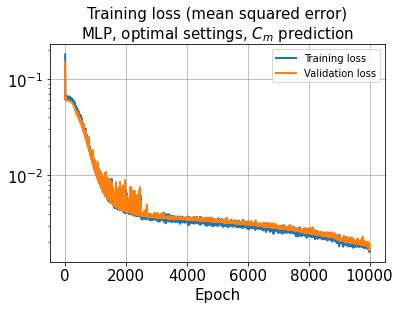

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

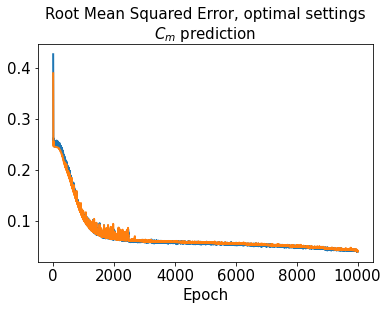

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

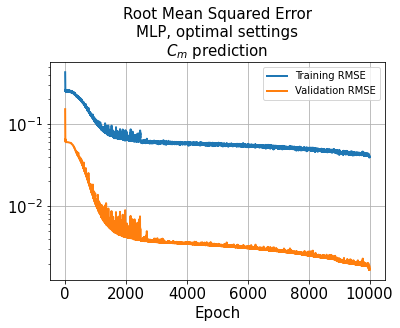

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 0.0017 - rmse: 0.0400


In [35]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 0.0017 - rmse: 0.0402


In [36]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 0.0016 - rmse: 0.0397


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [38]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [39]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [40]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [41]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.08620133756724542
2.8600091671812695


In [44]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.08731619023447953
2.9065043683328735


In [45]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.0866700410094046
2.977811124528271


In [46]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [47]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [48]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_WithParameters_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [49]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [52]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [53]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [54]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [55]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [56]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [57]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

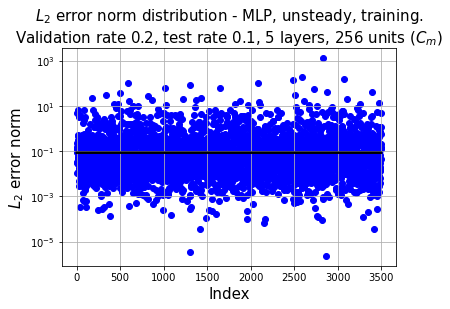

In [58]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

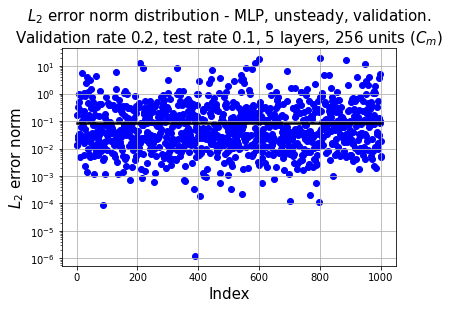

In [59]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

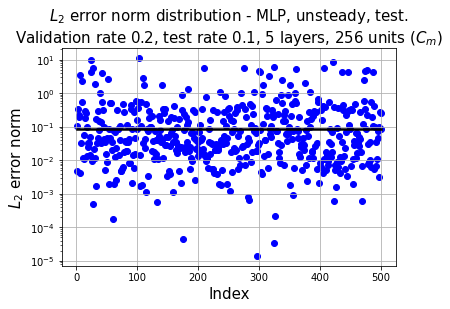

In [60]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [61]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [62]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [63]:
index_train.shape

(3499,)

In [64]:
max(predicted)

array([1.0167373], dtype=float32)

In [65]:
l2_error(denormalize(predicted), denormalize(y))

0.1201252117619076

In [66]:
l2_error(predicted, y)

0.08646972932807724

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [70]:
x[:,0] *= 5
x[:,0] += 10

L2 error of Cm: 0.0865


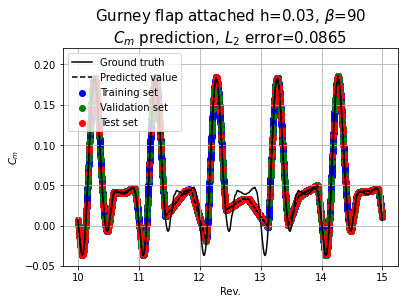

In [71]:
h = [0.03]
beta = [90]
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [72]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0865


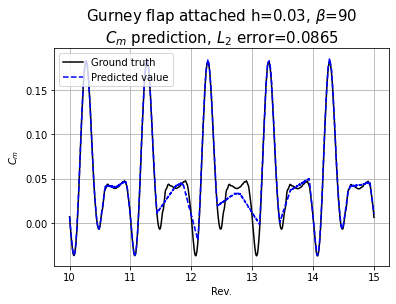

In [73]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0865


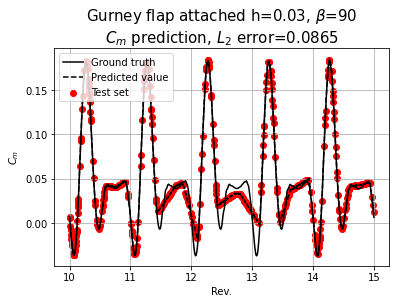

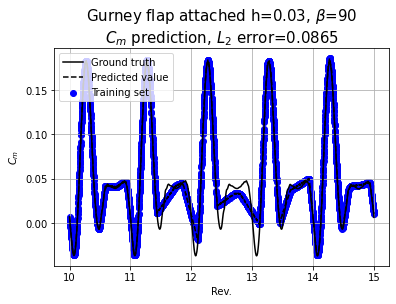

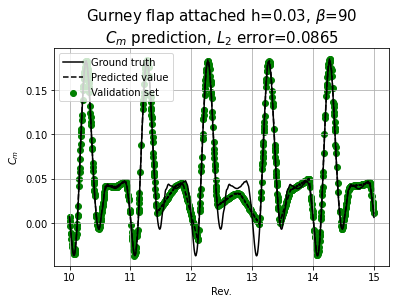

In [74]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()